<a href="https://colab.research.google.com/github/WillKWL/Project-NBAGames/blob/master/source/2_playoff_games_ML_workflow_average_precision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
# remove library not used
import pandas as pd
import numpy as np
import numpy as np
import re
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = [20, 5]
from matplotlib.pyplot import figure
import copy
from tqdm import tqdm
import seaborn as sns
from datetime import datetime

# packages for data_preparation pipeline
from scipy.stats import zscore
from matplotlib.patches import Rectangle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.decomposition import PCA 
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score, average_precision_score
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline

# packages for classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier

# packages for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# packages for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# packages for loading and dumping models
from google.colab import drive, files
import os
from joblib import dump, load

# packages for ensemble learning
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier

In [ ]:
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

# Read train set

In [ ]:
train_set = pd.read_pickle("https://github.com/WillKWL/PublicData/blob/main/raw/nba_pre_all_star_vs_playoff_games_train_comprehensive.pkl?raw=true")
train_set

,GAME_ID,TEAM_ID,TEAM_ID_OPP,GAME_DATE,MATCHUP,OUTCOME,HOME,SEASON,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,TEAM_NAME_OPP,GP_OPP,W_OPP,L_OPP,W_PCT_OPP,MIN_OPP,FGM_OPP,FGA_OPP,FG_PCT_OPP,FG3M_OPP,FG3A_OPP,FG3_PCT_OPP,FTM_OPP,FTA_OPP,FT_PCT_OPP,OREB_OPP,DREB_OPP,REB_OPP,AST_OPP,TOV_OPP,STL_OPP,BLK_OPP,BLKA_OPP,PF_OPP,PFD_OPP,PTS_OPP,PLUS_MINUS_OPP,CFID_OPP,CFPARAMS_OPP,AST_PCT_OPP,AST_RATIO_OPP,AST_TO_OPP,DEF_RATING_OPP,DREB_PCT_OPP,EFG_PCT_OPP,NET_RATING_OPP,OFF_RATING_OPP,OREB_PCT_OPP,PACE_OPP,PACE_PER40_OPP,PIE_OPP,POSS_OPP,REB_PCT_OPP,TM_TOV_PCT_OPP,TS_PCT_OPP,OPP_PTS_2ND_CHANCE_OPP,OPP_PTS_FB_OPP,OPP_PTS_OFF_TOV_OPP,OPP_PTS_PAINT_OPP,PTS_2ND_CHANCE_OPP,PTS_FB_OPP,PTS_OFF_TOV_OPP,PTS_PAINT_OPP,FTA_RATE_OPP,OPP_EFG_PCT_OPP,OPP_FTA_RATE_OPP,OPP_OREB_PCT_OPP,OPP_TOV_PCT_OPP,PCT_AST_2PM_OPP,PCT_AST_3PM_OPP,PCT_AST_FGM_OPP,PCT_FGA_2PT_OPP,PCT_FGA_3PT_OPP,PCT_PTS_2PT_OPP,PCT_PTS_2PT_MR_OPP,PCT_PTS_3PT_OPP,PCT_PTS_FB_OPP,PCT_PTS_FT_OPP,PCT_PTS_OFF_TOV_OPP,PCT_PTS_PAINT_OPP,PCT_UAST_2PM_OPP,PCT_UAST_3PM_OPP,PCT_UAST_FGM_OPP,OPP_AST_OPP,OPP_BLK_OPP,OPP_BLKA_OPP,OPP_DREB_OPP,OPP_FG3A_OPP,OPP_FG3M_OPP,OPP_FG3_PCT_OPP,OPP_FGA_OPP,OPP_FGM_OPP,OPP_FG_PCT_OPP,OPP_FTA_OPP,OPP_FTM_OPP,OPP_FT_PCT_OPP,OPP_OREB_OPP,OPP_PF_OPP,OPP_PFD_OPP,OPP_PTS_OPP,OPP_REB_OPP,OPP_STL_OPP,OPP_TOV_OPP,UNIQUE_ID
0,49600001,1610612766,1610612752,1997-04-24,CHH @ NYK,0,0,1996-97,Charlotte Hornets,48,29,19,0.604,53.4,39.3,85.6,0.459,7.7,18.2,0.424,20.4,26.7,0.763,12.4,31.0,43.4,26.4,16.4,7.7,4.4,5.1,23.6,0.2,106.6,-0.1,10,Charlotte Hornets,0.674,18.7,1.61,106.4,0.662,0.504,0.2,106.6,0.316,90.00,75.00,0.512,4333,0.493,0.164,0.548,17.1,12.3,18.3,45.6,13.5,11.2,18.1,40.3,0.312,0.496,0.275,0.338,0.154,0.630,0.853,0.674,0.788,0.212,0.592,0.214,0.217,0.105,0.191,0.170,0.378,0.370,0.147,0.326,23.7,5.1,4.4,31.3,18.5,6.8,0.368,89.6,41.0,0.458,24.7,17.8,0.723,14.3,24.3,23.6,106.7,45.6,7.2,15.4,New York Knicks,48,34,14,0.708,52.0,38.1,82.9,0.459,6.2,17.0,0.368,19.7,26.3,0.750,13.5,32.7,46.3,23.7,20.0,8.7,5.4,3.9,26.9,0.1,102.1,3.8,10,New York Knicks,0.622,17.0,1.18,98.2,0.697,0.497,3.9,102.1,0.335,92.40,77.00,0.536,4452,0.520,0.200,0.541,13.6,8.7,20.4,35.3,15.3,12.6,20.7,42.3,0.318,0.466,0.389,0.303,0.190,0.593,0.773,0.622,0.795,0.205,0.623,0.209,0.183,0.123,0.193,0.202,0.414,0.407,0.227,0.378,20.9,3.9,5.4,29.3,18.4,6.6,0.360,81.0,34.4,0.425,31.5,22.9,0.726,11.7,24.2,26.9,98.3,41.0,9.9,19.0,49600001199697
1,49600010,1610612766,1610612752,1997-04-26,CHH @ NYK,0,0,1996-97,Charlotte Hornets,48,29,19,0.604,53.4,39.3,85.6,0.459,7.7,18.2,0.424,20.4,26.7,0.763,12.4,31.0,43.4,26.4,16.4,7.7,4.4,5.1,23.6,0.2,106.6,-0.1,10,Charlotte Hornets,0.674,18.7,1.61,106.4,0.662,0.504,0.2,106.6,0.316,90.00,75.00,0.512,4333,0.493,0.164,0.548,17.1,12.3,18.3,45.6,13.5,11.2,18.1,40.3,0.312,0.496,0.275,0.338,0.154,0.630,0.853,0.674,0.788,0.212,0.592,0.214,0.217,0.105,0.191,0.170,0.378,0.370,0.147,0.326,23.7,5.1,4.4,31.3,18.5,6.8,0.368,89.6,41.0,0.458,24.7,17.8,0.723,14.3,24.3,23.6,106.7,45.6,7.2,15.4,New York Knicks,48,34,14,0.708,52.0,38.1,82.9,0.459,6.2,17.0,0.368,19.7,26.3,0.750,13.5,32.7,46.3,23.7,20.0,8.7,5.4,3.9,26.9,0.1,102.1,3.8,10,New York Knicks,0.622,17.0,1.18,98.2,0.697,0.497,3.9,102.1,0.335,92.40,77.00,0.536,4452,0.520,0.200,0.541,13.6,8

# Exploratory data analysis
- dataset set can be split into left and right half
- features = team stats
- Y = PLAYOFF_RANKING

In [ ]:
pd.DataFrame(train_set.dtypes).T

,GAME_ID,TEAM_ID,TEAM_ID_OPP,GAME_DATE,MATCHUP,OUTCOME,HOME,SEASON,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,TEAM_NAME_OPP,GP_OPP,W_OPP,L_OPP,W_PCT_OPP,MIN_OPP,FGM_OPP,FGA_OPP,FG_PCT_OPP,FG3M_OPP,FG3A_OPP,FG3_PCT_OPP,FTM_OPP,FTA_OPP,FT_PCT_OPP,OREB_OPP,DREB_OPP,REB_OPP,AST_OPP,TOV_OPP,STL_OPP,BLK_OPP,BLKA_OPP,PF_OPP,PFD_OPP,PTS_OPP,PLUS_MINUS_OPP,CFID_OPP,CFPARAMS_OPP,AST_PCT_OPP,AST_RATIO_OPP,AST_TO_OPP,DEF_RATING_OPP,DREB_PCT_OPP,EFG_PCT_OPP,NET_RATING_OPP,OFF_RATING_OPP,OREB_PCT_OPP,PACE_OPP,PACE_PER40_OPP,PIE_OPP,POSS_OPP,REB_PCT_OPP,TM_TOV_PCT_OPP,TS_PCT_OPP,OPP_PTS_2ND_CHANCE_OPP,OPP_PTS_FB_OPP,OPP_PTS_OFF_TOV_OPP,OPP_PTS_PAINT_OPP,PTS_2ND_CHANCE_OPP,PTS_FB_OPP,PTS_OFF_TOV_OPP,PTS_PAINT_OPP,FTA_RATE_OPP,OPP_EFG_PCT_OPP,OPP_FTA_RATE_OPP,OPP_OREB_PCT_OPP,OPP_TOV_PCT_OPP,PCT_AST_2PM_OPP,PCT_AST_3PM_OPP,PCT_AST_FGM_OPP,PCT_FGA_2PT_OPP,PCT_FGA_3PT_OPP,PCT_PTS_2PT_OPP,PCT_PTS_2PT_MR_OPP,PCT_PTS_3PT_OPP,PCT_PTS_FB_OPP,PCT_PTS_FT_OPP,PCT_PTS_OFF_TOV_OPP,PCT_PTS_PAINT_OPP,PCT_UAST_2PM_OPP,PCT_UAST_3PM_OPP,PCT_UAST_FGM_OPP,OPP_AST_OPP,OPP_BLK_OPP,OPP_BLKA_OPP,OPP_DREB_OPP,OPP_FG3A_OPP,OPP_FG3M_OPP,OPP_FG3_PCT_OPP,OPP_FGA_OPP,OPP_FGM_OPP,OPP_FG_PCT_OPP,OPP_FTA_OPP,OPP_FTM_OPP,OPP_FT_PCT_OPP,OPP_OREB_OPP,OPP_PF_OPP,OPP_PFD_OPP,OPP_PTS_OPP,OPP_REB_OPP,OPP_STL_OPP,OPP_TOV_OPP,UNIQUE_ID
0,object,object,object,datetime64[ns],object,int64,int64,category,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object


In [ ]:
train_set.describe()

,OUTCOME,HOME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,GP_OPP,W_OPP,L_OPP,W_PCT_OPP,MIN_OPP,FGM_OPP,FGA_OPP,FG_PCT_OPP,FG3M_OPP,FG3A_OPP,FG3_PCT_OPP,FTM_OPP,FTA_OPP,FT_PCT_OPP,OREB_OPP,DREB_OPP,REB_OPP,AST_OPP,TOV_OPP,STL_OPP,BLK_OPP,BLKA_OPP,PF_OPP,PFD_OPP,PTS_OPP,PLUS_MINUS_OPP,AST_PCT_OPP,AST_RATIO_OPP,AST_TO_OPP,DEF_RATING_OPP,DREB_PCT_OPP,EFG_PCT_OPP,NET_RATING_OPP,OFF_RATING_OPP,OREB_PCT_OPP,PACE_OPP,PACE_PER40_OPP,PIE_OPP,POSS_OPP,REB_PCT_OPP,TM_TOV_PCT_OPP,TS_PCT_OPP,OPP_PTS_2ND_CHANCE_OPP,OPP_PTS_FB_OPP,OPP_PTS_OFF_TOV_OPP,OPP_PTS_PAINT_OPP,PTS_2ND_CHANCE_OPP,PTS_FB_OPP,PTS_OFF_TOV_OPP,PTS_PAINT_OPP,FTA_RATE_OPP,OPP_EFG_PCT_OPP,OPP_FTA_RATE_OPP,OPP_OREB_PCT_OPP,OPP_TOV_PCT_OPP,PCT_AST_2PM_OPP,PCT_AST_3PM_OPP,PCT_AST_FGM_OPP,PCT_FGA_2PT_OPP,PCT_FGA_3PT_OPP,PCT_PTS_2PT_OPP,PCT_PTS_2PT_MR_OPP,PCT_PTS_3PT_OPP,PCT_PTS_FB_OPP,PCT_PTS_FT_OPP,PCT_PTS_OFF_TOV_OPP,PCT_PTS_PAINT_OPP,PCT_UAST_2PM_OPP,PCT_UAST_3PM_OPP,PCT_UAST_FGM_OPP,OPP_AST_OPP,OPP_BLK_OPP,OPP_BLKA_OPP,OPP_DREB_OPP,OPP_FG3A_OPP,OPP_FG3M_OPP,OPP_FG3_PCT_OPP,OPP_FGA_OPP,OPP_FGM_OPP,OPP_FG_PCT_OPP,OPP_FTA_OPP,OPP_FTM_OPP,OPP_FT_PCT_OPP,OPP_OREB_OPP,OPP_PF_OPP,OPP_PFD_OPP,OPP_PTS_OPP,OPP_REB_OPP,OPP_STL_OPP,OPP_TOV_OPP
count,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.00000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3

In [ ]:
# no missing data
train_set.isna().sum()[train_set.isna().sum() != 0]

Series([], dtype: int64)

In [ ]:
numeric_col = train_set.select_dtypes(include=np.number).columns.values.tolist()
print(f"number of numeric columns: {len(numeric_col)}")

number of numeric columns: 182


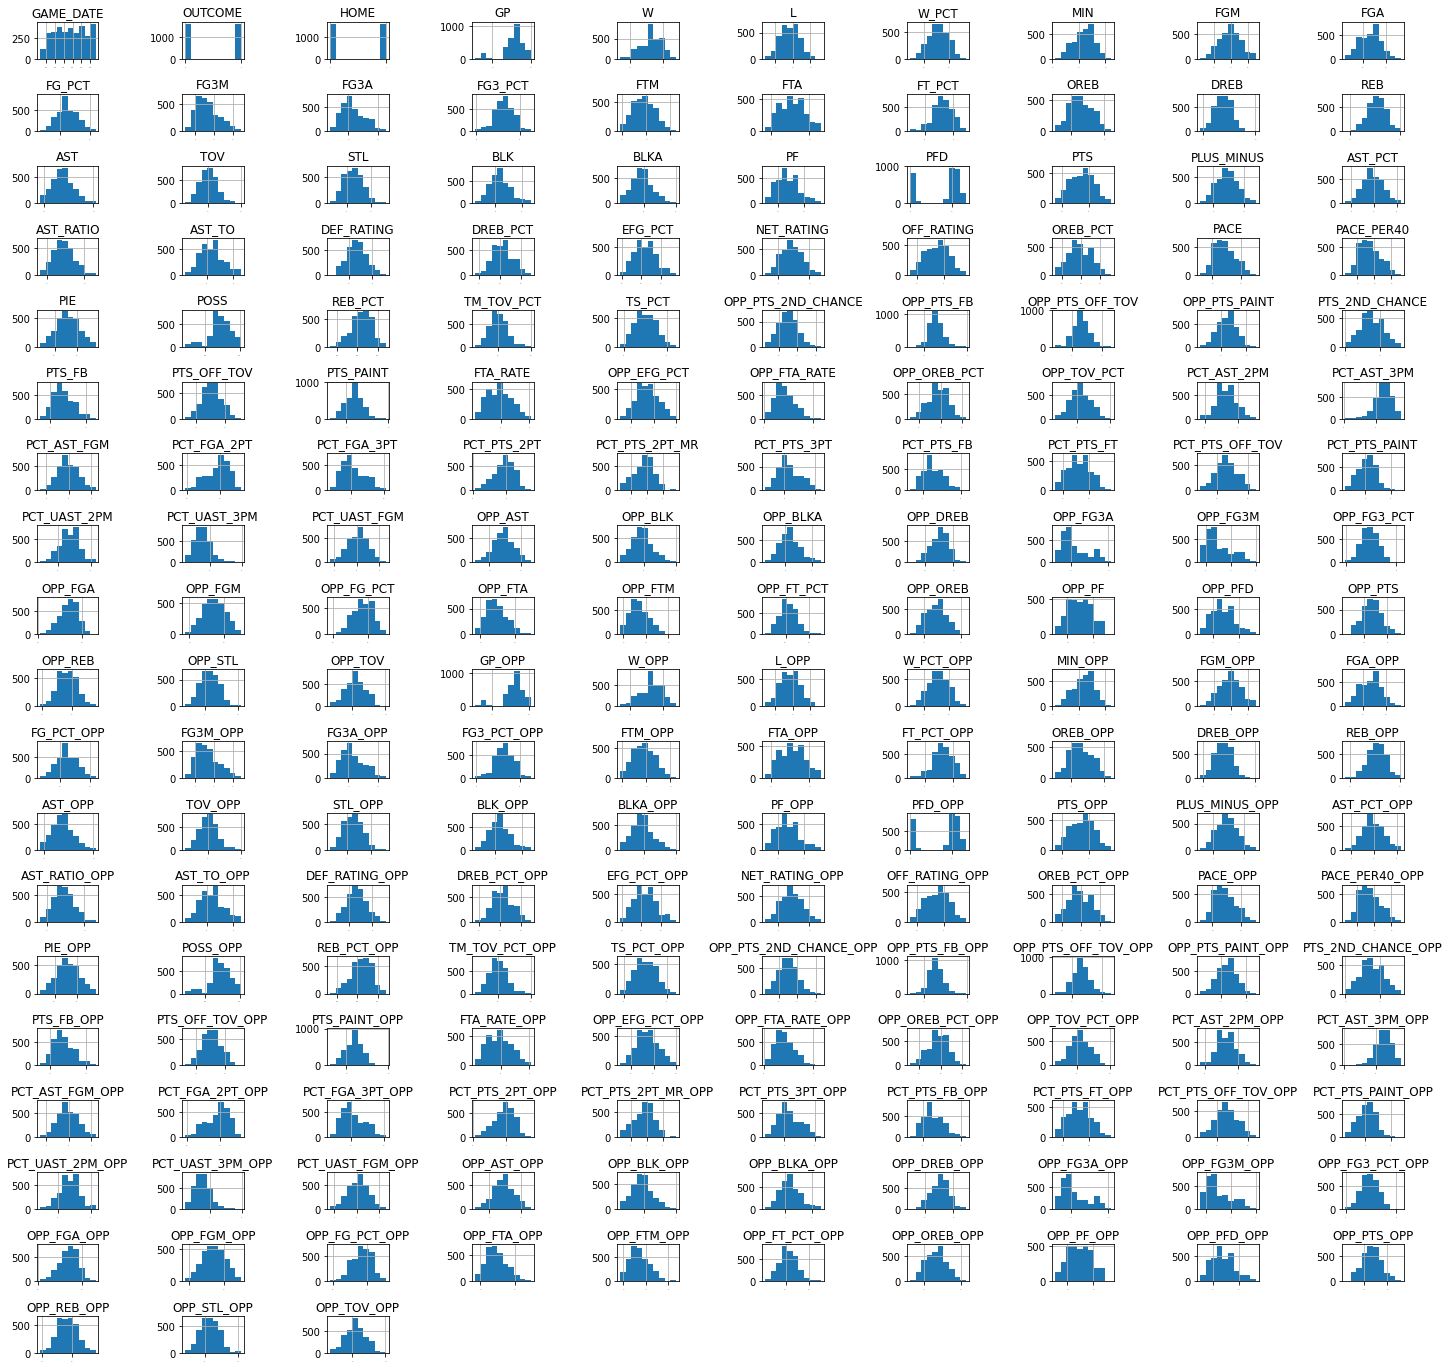

In [ ]:
# plot distributions of each numeric column
train_set.hist(bins=10, layout = (20, int(len(numeric_col) / 20) + 1), figsize= (20,20), xlabelsize=0)
plt.tight_layout()
plt.show()

## No class imbalance in y

In [ ]:
train_set.OUTCOME.value_counts(normalize=True)*100

1    50.015898
0    49.984102
Name: OUTCOME, dtype: float64

## Outliers in PFD and PFD_OPP - to be fixed in num_pipeline

In [ ]:
# equivalent measure: PFD (# of fouls drawn) = OPP_PF (# of fouls committed by opponent)
# outlier: PFD (Personal Fouls Drawn) with a high frequency at 0 
train_set.PFD.value_counts(bins = 10).sort_index()

(-0.027700000000000002, 2.67]    825
(2.67, 5.34]                      49
(5.34, 8.01]                       0
(8.01, 10.68]                      0
(10.68, 13.35]                     0
(13.35, 16.02]                     0
(16.02, 18.69]                   120
(18.69, 21.36]                   954
(21.36, 24.03]                   915
(24.03, 26.7]                    282
Name: PFD, dtype: int64

In [ ]:
# while OPP_PF (ie PFD) has a more even distribution
# consider replacing PFD with OPP_PF
train_set.OPP_PF.value_counts(bins = 10).sort_index()

(17.688, 18.76]    120
(18.76, 19.82]     265
(19.82, 20.88]     501
(20.88, 21.94]     492
(21.94, 23.0]      539
(23.0, 24.06]      416
(24.06, 25.12]     435
(25.12, 26.18]     186
(26.18, 27.24]     185
(27.24, 28.3]        6
Name: OPP_PF, dtype: int64

In [ ]:
# equivalent measure: PFD_OPP (# of fouls drawn) = OPP_PF (# of fouls committed by opponent)
# outlier: PFD_OPP (Personal Fouls Drawn) with a high frequency at 0 
train_set.PFD_OPP.value_counts(bins = 10).sort_index()

(-0.027700000000000002, 2.67]    825
(2.67, 5.34]                      49
(5.34, 8.01]                       0
(8.01, 10.68]                      0
(10.68, 13.35]                     0
(13.35, 16.02]                     0
(16.02, 18.69]                   120
(18.69, 21.36]                   951
(21.36, 24.03]                   918
(24.03, 26.7]                    282
Name: PFD_OPP, dtype: int64

In [ ]:
# while OPP_PF_OPP (ie PFD_OPP) has a more even distribution
# consider replacing PFD_OPP with OPP_PF_OPP
train_set.OPP_PF_OPP.value_counts(bins = 10).sort_index()

(17.688, 18.76]    120
(18.76, 19.82]     265
(19.82, 20.88]     498
(20.88, 21.94]     495
(21.94, 23.0]      539
(23.0, 24.06]      416
(24.06, 25.12]     435
(25.12, 26.18]     186
(26.18, 27.24]     185
(27.24, 28.3]        6
Name: OPP_PF_OPP, dtype: int64

## Correlation matrix

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


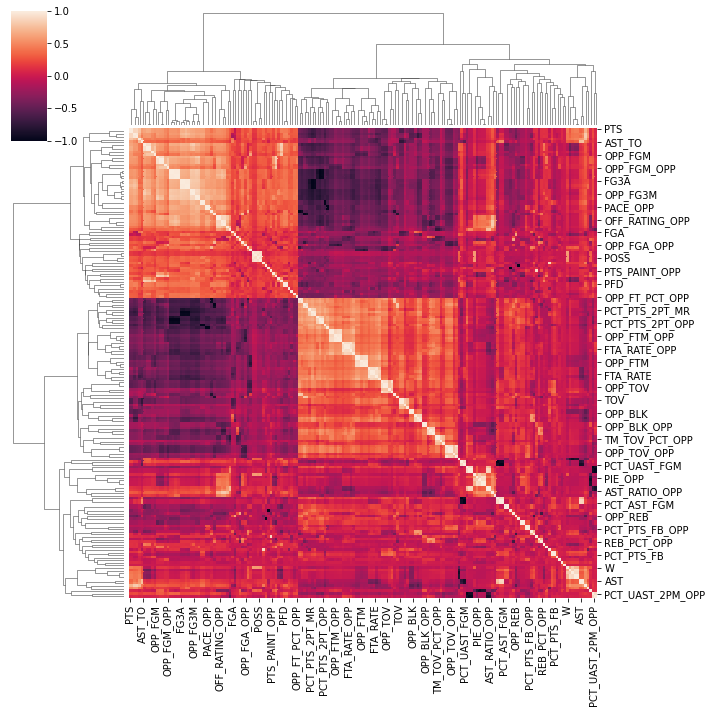

In [ ]:
corr_mat = train_set.corr()
# plt.figure(figsize=(20,20))
# sns.heatmap(corr_mat, 
#             annot=False, 
#             vmin=-1,
#             vmax=1,
#             mask = np.triu(corr_mat)) # to show only lower triangle
# plt.show()

# use dendrogram to see clusters
# offense and defensive stats tend to cluster with each other
sns.clustermap(corr_mat)

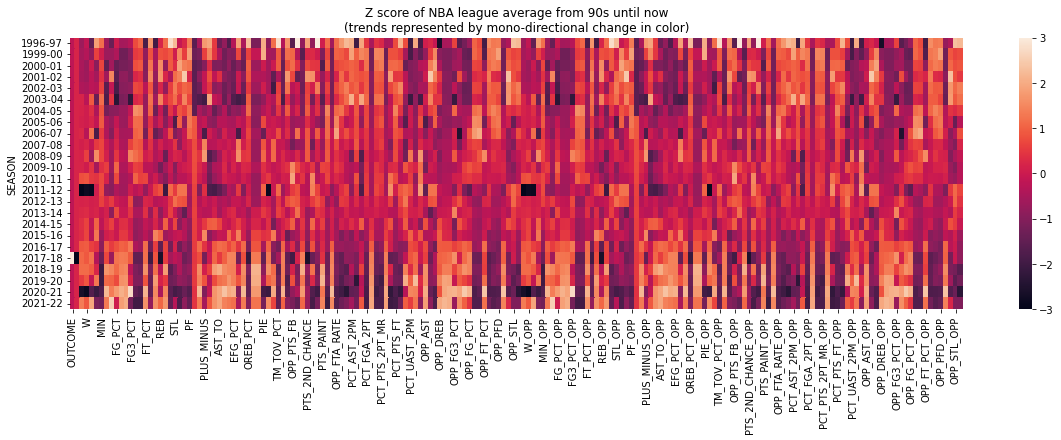

In [ ]:
# it's often mentioned that NBA teams in different era play with different styles
# we have already adjusted the stats per possession so pace doesn't impact the numbers here
# in 90s, teams tend to focus more on defense and are more physical (higher PF, BLK, STL, TOV)
# in recent era, teams shoot more 3s and score more points (FG and FG3)
# Feature engineering: clustering for SEASON to take into account this difference 
ax = sns.heatmap(train_set.loc[:,numeric_col + ["SEASON"]].groupby("SEASON").mean().apply(zscore),
                 vmin=-3, vmax=3)
plt.title("Z score of NBA league average from 90s until now\n(trends represented by mono-directional change in color)")
# for col in [
#     ("FGA"), ("FG3A"), ("TOV", "STL", "BLK", "BLKA", "PF"),
#     ('OPP_FTA_RATE', 'OPP_TOV_PCT', 'OPP_OREB_PCT'),
#     ('OPP_TOV', 'OPP_STL', 'OPP_BLK', 'OPP_BLKA', 'OPP_PF', 'OPP_PFD')
#     ]:
#   if type(col) is not str:
#     ax.add_patch(Rectangle((numeric_col.index(col[0]), 0), len(col), len(train_set.SEASON.unique()), fill=False, edgecolor="blue", lw=4, clip_on=False))
#   else:
#     ax.add_patch(Rectangle((numeric_col.index(col), 0), 1, len(train_set.SEASON.unique()), fill=False, edgecolor="blue", lw=4, clip_on=False))
plt.show()

# Data preparation
- No class imbalance to deal with
- Data cleaning
  - Transformations done at dataset level so not included in pipeline
    - Drop irrelevant columns, e.g. GP (Games Played) is 82 for most seasons and stats are already normalized per 100 possessions
    - Remove outlier seasons in terms of GP (Games Played)
  - Fix PFD column with OPP_PF column
  - Feature scaling
    - Scale numeric variables by MinMaxScaler 
  
- Feature engineering
  - Cluster similar seasons together with KMeans to represent different NBA eras

- (Skipped for interpretability) Dimensionality reduction
  - PCA to speed up random forest and fix axis orientation issue with decision tree

- Feature selection
  - Use L1 regularization to drop useless features

In [ ]:
# make a copy and split X and y
season = train_set.drop(columns = "OUTCOME").reset_index(drop = True).copy(deep = True)
season_label = train_set[["OUTCOME"]].values.reshape(-1,)

In [ ]:
# X_train before data preparation
season

,GAME_ID,TEAM_ID,TEAM_ID_OPP,GAME_DATE,MATCHUP,HOME,SEASON,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,TEAM_NAME_OPP,GP_OPP,W_OPP,L_OPP,W_PCT_OPP,MIN_OPP,FGM_OPP,FGA_OPP,FG_PCT_OPP,FG3M_OPP,FG3A_OPP,FG3_PCT_OPP,FTM_OPP,FTA_OPP,FT_PCT_OPP,OREB_OPP,DREB_OPP,REB_OPP,AST_OPP,TOV_OPP,STL_OPP,BLK_OPP,BLKA_OPP,PF_OPP,PFD_OPP,PTS_OPP,PLUS_MINUS_OPP,CFID_OPP,CFPARAMS_OPP,AST_PCT_OPP,AST_RATIO_OPP,AST_TO_OPP,DEF_RATING_OPP,DREB_PCT_OPP,EFG_PCT_OPP,NET_RATING_OPP,OFF_RATING_OPP,OREB_PCT_OPP,PACE_OPP,PACE_PER40_OPP,PIE_OPP,POSS_OPP,REB_PCT_OPP,TM_TOV_PCT_OPP,TS_PCT_OPP,OPP_PTS_2ND_CHANCE_OPP,OPP_PTS_FB_OPP,OPP_PTS_OFF_TOV_OPP,OPP_PTS_PAINT_OPP,PTS_2ND_CHANCE_OPP,PTS_FB_OPP,PTS_OFF_TOV_OPP,PTS_PAINT_OPP,FTA_RATE_OPP,OPP_EFG_PCT_OPP,OPP_FTA_RATE_OPP,OPP_OREB_PCT_OPP,OPP_TOV_PCT_OPP,PCT_AST_2PM_OPP,PCT_AST_3PM_OPP,PCT_AST_FGM_OPP,PCT_FGA_2PT_OPP,PCT_FGA_3PT_OPP,PCT_PTS_2PT_OPP,PCT_PTS_2PT_MR_OPP,PCT_PTS_3PT_OPP,PCT_PTS_FB_OPP,PCT_PTS_FT_OPP,PCT_PTS_OFF_TOV_OPP,PCT_PTS_PAINT_OPP,PCT_UAST_2PM_OPP,PCT_UAST_3PM_OPP,PCT_UAST_FGM_OPP,OPP_AST_OPP,OPP_BLK_OPP,OPP_BLKA_OPP,OPP_DREB_OPP,OPP_FG3A_OPP,OPP_FG3M_OPP,OPP_FG3_PCT_OPP,OPP_FGA_OPP,OPP_FGM_OPP,OPP_FG_PCT_OPP,OPP_FTA_OPP,OPP_FTM_OPP,OPP_FT_PCT_OPP,OPP_OREB_OPP,OPP_PF_OPP,OPP_PFD_OPP,OPP_PTS_OPP,OPP_REB_OPP,OPP_STL_OPP,OPP_TOV_OPP,UNIQUE_ID
0,49600001,1610612766,1610612752,1997-04-24,CHH @ NYK,0,1996-97,Charlotte Hornets,48,29,19,0.604,53.4,39.3,85.6,0.459,7.7,18.2,0.424,20.4,26.7,0.763,12.4,31.0,43.4,26.4,16.4,7.7,4.4,5.1,23.6,0.2,106.6,-0.1,10,Charlotte Hornets,0.674,18.7,1.61,106.4,0.662,0.504,0.2,106.6,0.316,90.00,75.00,0.512,4333,0.493,0.164,0.548,17.1,12.3,18.3,45.6,13.5,11.2,18.1,40.3,0.312,0.496,0.275,0.338,0.154,0.630,0.853,0.674,0.788,0.212,0.592,0.214,0.217,0.105,0.191,0.170,0.378,0.370,0.147,0.326,23.7,5.1,4.4,31.3,18.5,6.8,0.368,89.6,41.0,0.458,24.7,17.8,0.723,14.3,24.3,23.6,106.7,45.6,7.2,15.4,New York Knicks,48,34,14,0.708,52.0,38.1,82.9,0.459,6.2,17.0,0.368,19.7,26.3,0.750,13.5,32.7,46.3,23.7,20.0,8.7,5.4,3.9,26.9,0.1,102.1,3.8,10,New York Knicks,0.622,17.0,1.18,98.2,0.697,0.497,3.9,102.1,0.335,92.40,77.00,0.536,4452,0.520,0.200,0.541,13.6,8.7,20.4,35.3,15.3,12.6,20.7,42.3,0.318,0.466,0.389,0.303,0.190,0.593,0.773,0.622,0.795,0.205,0.623,0.209,0.183,0.123,0.193,0.202,0.414,0.407,0.227,0.378,20.9,3.9,5.4,29.3,18.4,6.6,0.360,81.0,34.4,0.425,31.5,22.9,0.726,11.7,24.2,26.9,98.3,41.0,9.9,19.0,49600001199697
1,49600010,1610612766,1610612752,1997-04-26,CHH @ NYK,0,1996-97,Charlotte Hornets,48,29,19,0.604,53.4,39.3,85.6,0.459,7.7,18.2,0.424,20.4,26.7,0.763,12.4,31.0,43.4,26.4,16.4,7.7,4.4,5.1,23.6,0.2,106.6,-0.1,10,Charlotte Hornets,0.674,18.7,1.61,106.4,0.662,0.504,0.2,106.6,0.316,90.00,75.00,0.512,4333,0.493,0.164,0.548,17.1,12.3,18.3,45.6,13.5,11.2,18.1,40.3,0.312,0.496,0.275,0.338,0.154,0.630,0.853,0.674,0.788,0.212,0.592,0.214,0.217,0.105,0.191,0.170,0.378,0.370,0.147,0.326,23.7,5.1,4.4,31.3,18.5,6.8,0.368,89.6,41.0,0.458,24.7,17.8,0.723,14.3,24.3,23.6,106.7,45.6,7.2,15.4,New York Knicks,48,34,14,0.708,52.0,38.1,82.9,0.459,6.2,17.0,0.368,19.7,26.3,0.750,13.5,32.7,46.3,23.7,20.0,8.7,5.4,3.9,26.9,0.1,102.1,3.8,10,New York Knicks,0.622,17.0,1.18,98.2,0.697,0.497,3.9,102.1,0.335,92.40,77.00,0.536,4452,0.520,0.200,0.541,13.6,8.7,20.4,35.3

In [ ]:
# y_train before data preparation
season_label

array([0, 0, 0, ..., 0, 1, 1])

## (Skip) Feature engineering - NewColumn

In [ ]:
# # create a custom transformer to perform numerical operations on columns 
# # FunctionTransformer cannot be used in pipeline since the version in Google Colab does not support passing feature names in
# class NewColumn(BaseEstimator, TransformerMixin):
#   def __init__(self):
#     pass
  
#   def fit(self, X, y = None):
#     return self
  
#   def transform(self, X):
#     # 2 Point Field Goals Attempted = All Field Goals Attempted - 3 Point Field Goals Attempted
#     output = copy.deepcopy(X)
#     output['FG2A'] = output['FGA'] - output['FG3A']
#     # 2 Point Field Goals Made
#     output['FG2M'] = output['FGM'] - output['FG3M']
#     # Percentage of 2 Point Field Goals Made
#     output['FG2_PCT'] = output['FG2M'] / output['FG2A']
#     # Ratio of 2 Point Field Goals Attempted to 3 Point Field Goals Attempted
#     output['FG2_FG3'] = output['FG2A'] / output['FG3A']
#     self.output_names = output.columns
#     return output
  
#   def get_feature_names_out(self, names = None):
#     return self.output_names

In [ ]:
# NewColumn().fit_transform(season)

## Feature scaling - num_pipeline
- Custom transformers to fix and drop columns
- Scale numeric features by normal quantiles
  - feature scaling to help gradient descent converge

In [ ]:
# create a custom transformer to fix PFD by replacing it with OPP_PF
class FixPF(BaseEstimator, TransformerMixin):
  def __init__(self, col_drop, col_replace):
    self.col_drop = col_drop
    self.col_replace = col_replace
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output[[self.col_drop]] = output[[self.col_replace]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names
  
# create a custom transformer to drop columns
class DropCols(BaseEstimator, TransformerMixin):
  def __init__(self, cols_drop):
    self.cols_drop = cols_drop
  
  def fit(self, X, y = None):
    # print([x in X.columns for x in self.cols_drop])
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = output.loc[:, [x not in self.cols_drop for x in output.columns]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to suppress n_quantile <= n_samples warning
class MyQuantileTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, output_distribution, random_state):
    self.output_distribution = output_distribution
    self.random_state = random_state
  
  def fit(self, X, y = None):
    self.QuantileTransformer = QuantileTransformer(n_quantiles=min(1000, X.shape[0]), # set this to suppress warning due to small dataset
                                                   output_distribution = self.output_distribution,
                                                   random_state = self.random_state).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.QuantileTransformer.transform(output),
                          columns = X.columns)
    self.output_names = X.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names


# create customer transformer to pass as df instead of array
class MyMinMaxScaler(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    self.MinMaxScaler_ = MinMaxScaler().fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.MinMaxScaler_.transform(output),
                          columns = X.columns)
    self.output_names = X.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

In [ ]:
season.select_dtypes(include=np.number)

,HOME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,GP_OPP,W_OPP,L_OPP,W_PCT_OPP,MIN_OPP,FGM_OPP,FGA_OPP,FG_PCT_OPP,FG3M_OPP,FG3A_OPP,FG3_PCT_OPP,FTM_OPP,FTA_OPP,FT_PCT_OPP,OREB_OPP,DREB_OPP,REB_OPP,AST_OPP,TOV_OPP,STL_OPP,BLK_OPP,BLKA_OPP,PF_OPP,PFD_OPP,PTS_OPP,PLUS_MINUS_OPP,AST_PCT_OPP,AST_RATIO_OPP,AST_TO_OPP,DEF_RATING_OPP,DREB_PCT_OPP,EFG_PCT_OPP,NET_RATING_OPP,OFF_RATING_OPP,OREB_PCT_OPP,PACE_OPP,PACE_PER40_OPP,PIE_OPP,POSS_OPP,REB_PCT_OPP,TM_TOV_PCT_OPP,TS_PCT_OPP,OPP_PTS_2ND_CHANCE_OPP,OPP_PTS_FB_OPP,OPP_PTS_OFF_TOV_OPP,OPP_PTS_PAINT_OPP,PTS_2ND_CHANCE_OPP,PTS_FB_OPP,PTS_OFF_TOV_OPP,PTS_PAINT_OPP,FTA_RATE_OPP,OPP_EFG_PCT_OPP,OPP_FTA_RATE_OPP,OPP_OREB_PCT_OPP,OPP_TOV_PCT_OPP,PCT_AST_2PM_OPP,PCT_AST_3PM_OPP,PCT_AST_FGM_OPP,PCT_FGA_2PT_OPP,PCT_FGA_3PT_OPP,PCT_PTS_2PT_OPP,PCT_PTS_2PT_MR_OPP,PCT_PTS_3PT_OPP,PCT_PTS_FB_OPP,PCT_PTS_FT_OPP,PCT_PTS_OFF_TOV_OPP,PCT_PTS_PAINT_OPP,PCT_UAST_2PM_OPP,PCT_UAST_3PM_OPP,PCT_UAST_FGM_OPP,OPP_AST_OPP,OPP_BLK_OPP,OPP_BLKA_OPP,OPP_DREB_OPP,OPP_FG3A_OPP,OPP_FG3M_OPP,OPP_FG3_PCT_OPP,OPP_FGA_OPP,OPP_FGM_OPP,OPP_FG_PCT_OPP,OPP_FTA_OPP,OPP_FTM_OPP,OPP_FT_PCT_OPP,OPP_OREB_OPP,OPP_PF_OPP,OPP_PFD_OPP,OPP_PTS_OPP,OPP_REB_OPP,OPP_STL_OPP,OPP_TOV_OPP
0,0,48,29,19,0.604,53.4,39.3,85.6,0.459,7.7,18.2,0.424,20.4,26.7,0.763,12.4,31.0,43.4,26.4,16.4,7.7,4.4,5.1,23.6,0.2,106.6,-0.1,0.674,18.7,1.61,106.4,0.662,0.504,0.2,106.6,0.316,90.00,75.00,0.512,4333,0.493,0.164,0.548,17.1,12.3,18.3,45.6,13.5,11.2,18.1,40.3,0.312,0.496,0.275,0.338,0.154,0.630,0.853,0.674,0.788,0.212,0.592,0.214,0.217,0.105,0.191,0.170,0.378,0.370,0.147,0.326,23.7,5.1,4.4,31.3,18.5,6.8,0.368,89.6,41.0,0.458,24.7,17.8,0.723,14.3,24.3,23.6,106.7,45.6,7.2,15.4,48,34,14,0.708,52.0,38.1,82.9,0.459,6.2,17.0,0.368,19.7,26.3,0.750,13.5,32.7,46.3,23.7,20.0,8.7,5.4,3.9,26.9,0.1,102.1,3.8,0.622,17.0,1.18,98.2,0.697,0.497,3.9,102.1,0.335,92.40,77.00,0.536,4452,0.520,0.200,0.541,13.6,8.7,20.4,35.3,15.3,12.6,20.7,42.3,0.318,0.466,0.389,0.303,0.190,0.593,0.773,0.622,0.795,0.205,0.623,0.209,0.183,0.123,0.193,0.202,0.414,0.407,0.227,0.378,20.9,3.9,5.4,29.3,18.4,6.6,0.360,81.0,34.4,0.425,31.5,22.9,0.726,11.7,24.2,26.9,98.3,41.0,9.9,19.0
1,0,48,29,19,0.604,53.4,39.3,85.6,0.459,7.7,18.2,0.424,20.4,26.7,0.763,12.4,31.0,43.4,26.4,16.4,7.7,4.4,5.1,23.6,0.2,106.6,-0.1,0.674,18.7,1.61,106.4,0.662,0.504,0.2,106.6,0.316,90.00,75.00,0.512,4333,0.493,0.164,0.548,17.1,12.3,18.3,45.6,13.5,11.2,18.1,40.3,0.312,0.496,0.275,0.338,0.154,0.630,0.853,0.674,0.788,0.212,0.592,0.214,0.217,0.105,0.191,0.170,0.378,0.370,0.147,0.326,23.7,5.1,4.4,31.3,18.5,6.8,0.368,89.6,41.0,0.458,24.7,17.8,0.723,14.3,24.3,23.6,106.7,45.6,7.2,15.4,48,34,14,0.708,52.0,38.1,82.9,0.459,6.2,17.0,0.368,19.7,26.3,0.750,13.5,32.7,46.3,23.7,20.0,8.7,5.4,3.9,26.9,0.1,102.1,3.8,0.622,17.0,1.18,98.2,0.697,0.497,3.9,102.1,0.335,92.40,77.00,0.536,4452,0.520,0.200,0.541,13.6,8.7,20.4,35.3,15.3,12.6,20.7,42.3,0.318,0.466,0.389,0.303,0.190,0.593,0.773,0.622,0.795,0.205,0.623,0.209,0.183,0.123,0.193,0.202,0.414,0.407,0.227,0.378,20.9,3.9,5.4,29.3,18.4,6.6,0.360,81.0,34.4,0.425,31.5,22.9,0.726,11.7,24.2,26.9,98.3,41.0,9.9,19.0
2,1,48,36,12,0.750,53.7,37.6,83.6,0.449,8.6,23.9,0.361,19.7,27.8,0.709,12.9,33.0,46.0,22.7,18.3,8.4,6.5,5.4,26.1,0.2,103.5,5.6,0.603,16.4,1.24,98.1,0.679,0.501,5.4,10

In [ ]:
cols_to_drop = [
        # all teams have played 40-60 games (useless info)
        "GP",
        # knowing you win or lose a game is pointless, the question should be how you have won (e.g. score more points, lose fewer points)
        "W", "L", "W_PCT",      
        # drop PFD since not sure if player PFD is also wrong like team PFD
        "PFD",
        # you cannot control how long each game is played, depending on whether there are ties 
        "MIN",
        # you want to control FGA and FG_PCT
        "FGM", "FG3M", "FTM", 'OPP_FGM', 'OPP_FG3M', 'OPP_FTM',
        # unknown column
        "TM_TOV_PCT",
        # = OREB + DREB
        "REB", "REB_PCT",
        # keep breakdown between PTS and OPP_PTS
        "PLUS_MINUS",
        # same as PLUS_MINUS
        "NET_RATING",
        # only useful if comparing to 40-min games in NCAA
        "PACE_PER40",
        # same as PACE
        "POSS",
        # descriptive stat
        "PIE" 
]

# drop both * and _OPP together
cols_to_drop = cols_to_drop + [x + '_OPP' for x in cols_to_drop]

In [ ]:
num_pipeline = make_pipeline(
    
    # 1) replace PFD with OPP_PF since both columns should be the same but we saw issues with PFD column
    FixPF("PFD", "OPP_PF"),

    FixPF("PFD_OPP", "OPP_PF_OPP"),
    
    # 2) drop numerical columns which are not useful for interpretation
    DropCols(cols_to_drop),
    
    MyMinMaxScaler()
    # 3) feature scaling + outlier removal by transforming features into quantiles
    # some features have heavy tails, some look like uniform so let's use transform them all to uniform by quantile
    # instead of taking log for every feature
    # MyQuantileTransformer(output_distribution="uniform", random_state=42),

)

In [ ]:
# to be applied to only numeric columns
num_clean = pd.DataFrame(num_pipeline.fit_transform(season.select_dtypes(include=np.number)),
                         columns = num_pipeline.get_feature_names_out())
num_clean

,HOME,FGA,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PTS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,OFF_RATING,OREB_PCT,PACE,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3_PCT,OPP_FGA,OPP_FG_PCT,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,FGA_OPP,FG_PCT_OPP,FG3A_OPP,FG3_PCT_OPP,FTA_OPP,FT_PCT_OPP,OREB_OPP,DREB_OPP,AST_OPP,TOV_OPP,STL_OPP,BLK_OPP,BLKA_OPP,PF_OPP,PTS_OPP,AST_PCT_OPP,AST_RATIO_OPP,AST_TO_OPP,DEF_RATING_OPP,DREB_PCT_OPP,EFG_PCT_OPP,OFF_RATING_OPP,OREB_PCT_OPP,PACE_OPP,TS_PCT_OPP,OPP_PTS_2ND_CHANCE_OPP,OPP_PTS_FB_OPP,OPP_PTS_OFF_TOV_OPP,OPP_PTS_PAINT_OPP,PTS_2ND_CHANCE_OPP,PTS_FB_OPP,PTS_OFF_TOV_OPP,PTS_PAINT_OPP,FTA_RATE_OPP,OPP_EFG_PCT_OPP,OPP_FTA_RATE_OPP,OPP_OREB_PCT_OPP,OPP_TOV_PCT_OPP,PCT_AST_2PM_OPP,PCT_AST_3PM_OPP,PCT_AST_FGM_OPP,PCT_FGA_2PT_OPP,PCT_FGA_3PT_OPP,PCT_PTS_2PT_OPP,PCT_PTS_2PT_MR_OPP,PCT_PTS_3PT_OPP,PCT_PTS_FB_OPP,PCT_PTS_FT_OPP,PCT_PTS_OFF_TOV_OPP,PCT_PTS_PAINT_OPP,PCT_UAST_2PM_OPP,PCT_UAST_3PM_OPP,PCT_UAST_FGM_OPP,OPP_AST_OPP,OPP_BLK_OPP,OPP_BLKA_OPP,OPP_DREB_OPP,OPP_FG3A_OPP,OPP_FG3_PCT_OPP,OPP_FGA_OPP,OPP_FG_PCT_OPP,OPP_FTA_OPP,OPP_FT_PCT_OPP,OPP_OREB_OPP,OPP_PF_OPP,OPP_PFD_OPP,OPP_PTS_OPP,OPP_REB_OPP,OPP_STL_OPP,OPP_TOV_OPP
0,0.0,0.370968,0.463158,0.277333,1.000000,0.565517,0.588832,0.571429,0.141509,0.637168,0.576471,0.338983,0.250000,0.454545,0.566038,0.436893,0.817814,0.621622,0.495238,0.610879,0.160305,0.412587,0.436893,0.582192,0.219525,0.438462,0.864865,0.426357,0.655914,0.628440,0.4375,0.251613,0.520833,0.305660,0.523077,0.569106,0.314159,0.839695,0.447059,0.772455,0.704871,0.817814,0.711944,0.288056,0.538690,0.523256,0.395095,0.260274,0.522936,0.533333,0.265766,0.227545,0.295129,0.182186,0.674157,0.454545,0.250000,0.397959,0.234899,0.630631,0.716535,0.777778,0.386503,0.136752,0.815789,0.622642,0.566038,0.620833,0.634409,0.285714,0.447059,0.153226,0.463158,0.245333,0.559055,0.537931,0.522843,0.702381,0.301887,0.398230,1.000000,0.508475,0.442308,0.181818,0.877358,0.218447,0.607287,0.391892,0.085714,0.267782,0.427481,0.363636,0.218447,0.712329,0.340921,0.384615,0.391892,0.147287,0.881720,0.155963,0.6625,0.341935,0.791667,0.381132,0.553846,0.325203,0.818584,0.572519,0.870588,0.661677,0.475645,0.607287,0.728337,0.271663,0.630952,0.508721,0.302452,0.383562,0.541284,0.888889,0.427928,0.338323,0.524355,0.392713,0.359551,0.181818,0.442308,0.193878,0.231544,0.558559,0.039370,0.361446,0.803681,0.162393,0.473684,0.613208,0.877358,0.270833,0.139785,0.928571,0.870588
1,0.0,0.370968,0.463158,0.277333,1.000000,0.565517,0.588832,0.571429,0.141509,0.637168,0.576471,0.338983,0.250000,0.454545,0.566038,0.436893,0.817814,0.621622,0.495238,0.610879,0.160305,0.412587,0.436893,0.582192,0.219525,0.438462,0.864865,0.426357,0.655914,0.628440,0.4375,0.251613,0.520833,0.305660,0.523077,0.569106,0.314159,0.839695,0.447059,0.772455,0.704871,0.817814,0.711944,0.288056,0.538690,0.523256,0.395095,0.260274,0.522936,0.533333,0.265766,0.227545,0.295129,0.182186,0.674157,0.454545,0.250000,0.397959,0.234899,0.630631,0.716535,0.777778,0.386503,0.136752,0.815789,0.622642,0.566038,0.620833,0.634409,0.285714,0.447059,0.153226,0.463158,0.245333,0.559055,0.537931,0.522843,0.702381,0.301887,0.398230,1.000000,0.508475,0.442308,0.181818,0.877358,0.218447,0.607287,0.391892,0.085714,0.267782,0.427481,0.363636,0.218447,0.712329,0.340921,0.384615,0.391892,0.147287,0.881720,0.155963,0.6625,0.341935,0.791667,0.381132,0.553846,0.325203,0.818584,0.572519,0.870588,0.661677,0.475645,0.607287,0.728337,0.271663,0.630952,0.508721,0.302452,0.383562,0.541284,0.888889,0.427928,0.338323,0.524355,0.392713,0.359551,0.181818,0.442

In [ ]:
# check no identifier column
sorted(num_clean.columns)

['AST',
 'AST_OPP',
 'AST_PCT',
 'AST_PCT_OPP',
 'AST_RATIO',
 'AST_RATIO_OPP',
 'AST_TO',
 'AST_TO_OPP',
 'BLK',
 'BLKA',
 'BLKA_OPP',
 'BLK_OPP',
 'DEF_RATING',
 'DEF_RATING_OPP',
 'DREB',
 'DREB_OPP',
 'DREB_PCT',
 'DREB_PCT_OPP',
 'EFG_PCT',
 'EFG_PCT_OPP',
 'FG3A',
 'FG3A_OPP',
 'FG3_PCT',
 'FG3_PCT_OPP',
 'FGA',
 'FGA_OPP',
 'FG_PCT',
 'FG_PCT_OPP',
 'FTA',
 'FTA_OPP',
 'FTA_RATE',
 'FTA_RATE_OPP',
 'FT_PCT',
 'FT_PCT_OPP',
 'HOME',
 'OFF_RATING',
 'OFF_RATING_OPP',
 'OPP_AST',
 'OPP_AST_OPP',
 'OPP_BLK',
 'OPP_BLKA',
 'OPP_BLKA_OPP',
 'OPP_BLK_OPP',
 'OPP_DREB',
 'OPP_DREB_OPP',
 'OPP_EFG_PCT',
 'OPP_EFG_PCT_OPP',
 'OPP_FG3A',
 'OPP_FG3A_OPP',
 'OPP_FG3_PCT',
 'OPP_FG3_PCT_OPP',
 'OPP_FGA',
 'OPP_FGA_OPP',
 'OPP_FG_PCT',
 'OPP_FG_PCT_OPP',
 'OPP_FTA',
 'OPP_FTA_OPP',
 'OPP_FTA_RATE',
 'OPP_FTA_RATE_OPP',
 'OPP_FT_PCT',
 'OPP_FT_PCT_OPP',
 'OPP_OREB',
 'OPP_OREB_OPP',
 'OPP_OREB_PCT',
 'OPP_OREB_PCT_OPP',
 'OPP_PF',
 'OPP_PFD',
 'OPP_PFD_OPP',
 'OPP_PF_OPP',
 'OPP_PTS',
 'OPP_PTS

## Clustering - SeasonSimilarity
- After feature scaling (need to include in fit and transform methods of custom transformer instead of a step in pipeline object since we need the X as df instead of np array to group by SEASON
- Use silhouette score to measure performance of clustering
- Perform soft clustering on SEASON with KMeans to differentiate NBA eras

In [ ]:
# create a custom transformer to cluster nba seasons into era
class SeasonSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters = 3, random_state = None, best_silh = False):
    self.n_clusters = n_clusters
    self.random_state = random_state
    self.best_silh = best_silh
  
  def fit(self, X, y = None, sample_weight = None, plot_silh = False):
    self.feature_names_in_ = X.columns.values
    self.index_names = X.sort_index().index.values
    
    # find best k number of clusters based on silhouette score
    if self.best_silh:
      # test performance with silhouette score (distance from one's center and from other centers) from 2 to 10 clusters
      # don't consider tuning k as hyperparameter because silhouette score is more intuitive
      # e.g. clustering based on records from 1996 to 2022 (full range) vs clustering based on records from 2010 to 2022 (1st fold)
      k_range = np.arange(2,11,1)
      silh_scores = []
      for k in range(2,11):
        self.n_clusters = k
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        silh_scores.append(silhouette_score(X, self.kmeans_.labels_))
      
      max_k = k_range[np.argmax(silh_scores)]
      max_silh = max(silh_scores)
      self.n_clusters = max_k    

      # plot silhouette scores for 2 - 10 clusters
      if plot_silh:
        plt.plot(k_range, silh_scores)
        plt.xlabel("Number of clusters")
        plt.ylabel("Silhouette score")
        plt.title(f"optimal no. of cluster = {max_k}, silhouette score = {max_silh:0.4f}")
        plt.show()
    
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self
  
  def transform(self, X):
    # Soft Clustering: each column = distance to cluster i
    X_clusterdist = pd.DataFrame(self.kmeans_.transform(X),
                                 columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # Scaling: Quantile transform the cluster distances like other numerical columns
    # X_clusterdist = pd.DataFrame(MyQuantileTransformer(output_distribution="uniform", random_state=42).fit_transform(X_clusterdist),
    #                              columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # Scaling: MinMaxScale transform the cluster distances like other numerical columns
    X_clusterdist = pd.DataFrame(MyMinMaxScaler().fit_transform(X_clusterdist),
                                 columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # merge with numerical columns to return
    output = pd.concat([X, X_clusterdist], axis=1)
    self.output_features = output.columns.values
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_features

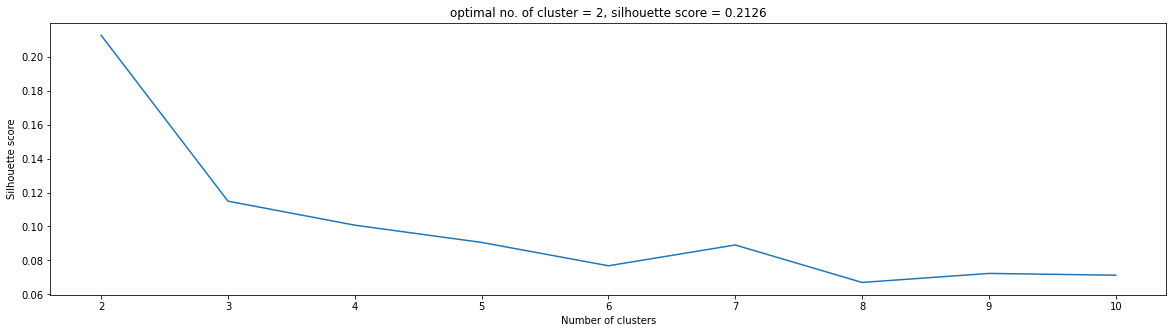

,HOME,FGA,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PTS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,OFF_RATING,OREB_PCT,PACE,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3_PCT,OPP_FGA,OPP_FG_PCT,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,FGA_OPP,FG_PCT_OPP,FG3A_OPP,FG3_PCT_OPP,FTA_OPP,FT_PCT_OPP,OREB_OPP,DREB_OPP,AST_OPP,TOV_OPP,STL_OPP,BLK_OPP,BLKA_OPP,PF_OPP,PTS_OPP,AST_PCT_OPP,AST_RATIO_OPP,AST_TO_OPP,DEF_RATING_OPP,DREB_PCT_OPP,EFG_PCT_OPP,OFF_RATING_OPP,OREB_PCT_OPP,PACE_OPP,TS_PCT_OPP,OPP_PTS_2ND_CHANCE_OPP,OPP_PTS_FB_OPP,OPP_PTS_OFF_TOV_OPP,OPP_PTS_PAINT_OPP,PTS_2ND_CHANCE_OPP,PTS_FB_OPP,PTS_OFF_TOV_OPP,PTS_PAINT_OPP,FTA_RATE_OPP,OPP_EFG_PCT_OPP,OPP_FTA_RATE_OPP,OPP_OREB_PCT_OPP,OPP_TOV_PCT_OPP,PCT_AST_2PM_OPP,PCT_AST_3PM_OPP,PCT_AST_FGM_OPP,PCT_FGA_2PT_OPP,PCT_FGA_3PT_OPP,PCT_PTS_2PT_OPP,PCT_PTS_2PT_MR_OPP,PCT_PTS_3PT_OPP,PCT_PTS_FB_OPP,PCT_PTS_FT_OPP,PCT_PTS_OFF_TOV_OPP,PCT_PTS_PAINT_OPP,PCT_UAST_2PM_OPP,PCT_UAST_3PM_OPP,PCT_UAST_FGM_OPP,OPP_AST_OPP,OPP_BLK_OPP,OPP_BLKA_OPP,OPP_DREB_OPP,OPP_FG3A_OPP,OPP_FG3_PCT_OPP,OPP_FGA_OPP,OPP_FG_PCT_OPP,OPP_FTA_OPP,OPP_FT_PCT_OPP,OPP_OREB_OPP,OPP_PF_OPP,OPP_PFD_OPP,OPP_PTS_OPP,OPP_REB_OPP,OPP_STL_OPP,OPP_TOV_OPP,ERA_0,ERA_1
0,0.0,0.370968,0.463158,0.277333,1.000000,0.565517,0.588832,0.571429,0.141509,0.637168,0.576471,0.338983,0.250000,0.454545,0.566038,0.436893,0.817814,0.621622,0.495238,0.610879,0.160305,0.412587,0.436893,0.582192,0.219525,0.438462,0.864865,0.426357,0.655914,0.628440,0.4375,0.251613,0.520833,0.305660,0.523077,0.569106,0.314159,0.839695,0.447059,0.772455,0.704871,0.817814,0.711944,0.288056,0.538690,0.523256,0.395095,0.260274,0.522936,0.533333,0.265766,0.227545,0.295129,0.182186,0.674157,0.454545,0.250000,0.397959,0.234899,0.630631,0.716535,0.777778,0.386503,0.136752,0.815789,0.622642,0.566038,0.620833,0.634409,0.285714,0.447059,0.153226,0.463158,0.245333,0.559055,0.537931,0.522843,0.702381,0.301887,0.398230,1.000000,0.508475,0.442308,0.181818,0.877358,0.218447,0.607287,0.391892,0.085714,0.267782,0.427481,0.363636,0.218447,0.712329,0.340921,0.384615,0.391892,0.147287,0.881720,0.155963,0.6625,0.341935,0.791667,0.381132,0.553846,0.325203,0.818584,0.572519,0.870588,0.661677,0.475645,0.607287,0.728337,0.271663,0.630952,0.508721,0.302452,0.383562,0.541284,0.888889,0.427928,0.338323,0.524355,0.392713,0.359551,0.181818,0.442308,0.193878,0.231544,0.558559,0.039370,0.361446,0.803681,0.162393,0.473684,0.613208,0.877358,0.270833,0.139785,0.928571,0.870588,0.768737,0.364008
1,0.0,0.370968,0.463158,0.277333,1.000000,0.565517,0.588832,0.571429,0.141509,0.637168,0.576471,0.338983,0.250000,0.454545,0.566038,0.436893,0.817814,0.621622,0.495238,0.610879,0.160305,0.412587,0.436893,0.582192,0.219525,0.438462,0.864865,0.426357,0.655914,0.628440,0.4375,0.251613,0.520833,0.305660,0.523077,0.569106,0.314159,0.839695,0.447059,0.772455,0.704871,0.817814,0.711944,0.288056,0.538690,0.523256,0.395095,0.260274,0.522936,0.533333,0.265766,0.227545,0.295129,0.182186,0.674157,0.454545,0.250000,0.397959,0.234899,0.630631,0.716535,0.777778,0.386503,0.136752,0.815789,0.622642,0.566038,0.620833,0.634409,0.285714,0.447059,0.153226,0.463158,0.245333,0.559055,0.537931,0.522843,0.702381,0.301887,0.398230,1.000000,0.508475,0.442308,0.181818,0.877358,0.218447,0.607287,0.391892,0.085714,0.267782,0.427481,0.363636,0.218447,0.712329,0.340921,0.384615,0.391892,0.147287,0.881720,0.155963,0.6625,0.341935,0.791667,0.381132,0.553846,0.325203,0.818584,0.572519,0.870588,0.661677,0.475645,0.607287,0.728337,0.271663,0.630952,0.508721,0.302452,0.383562,0.541284,0.888889,0.427928,0.338323,0.524355,0.

In [ ]:
fit_seasonsimilarity = SeasonSimilarity(random_state=42, best_silh=True).fit(num_clean, plot_silh=True)
season_prepared = pd.DataFrame(fit_seasonsimilarity.transform(num_clean),
                               columns = fit_seasonsimilarity.get_feature_names_out())
season_prepared

### add to num_pipeline

In [ ]:
# add to num_pipeline
num_pipeline.steps.append(
    ('season', SeasonSimilarity(random_state=42, n_clusters=2)) # choose 2 here instead of tuning as a hyperparameter
)

In [ ]:
num_pipeline

Pipeline(steps=[('fixpf-1', FixPF(col_drop='PFD', col_replace='OPP_PF')),
                ('fixpf-2',
                 FixPF(col_drop='PFD_OPP', col_replace='OPP_PF_OPP')),
                ('dropcols',
                 DropCols(cols_drop=['GP', 'W', 'L', 'W_PCT', 'PFD', 'MIN',
                                     'FGM', 'FG3M', 'FTM', 'OPP_FGM',
                                     'OPP_FG3M', 'OPP_FTM', 'TM_TOV_PCT', 'REB',
                                     'REB_PCT', 'PLUS_MINUS', 'NET_RATING',
                                     'PACE_PER40', 'POSS', 'PIE', 'GP_OPP',
                                     'W_OPP', 'L_OPP', 'W_PCT_OPP', 'PFD_OPP',
                                     'MIN_OPP', 'FGM_OPP', 'FG3M_OPP',
                                     'FTM_OPP', 'OPP_FGM_OPP', ...])),
                ('myminmaxscaler', MyMinMaxScaler()),
                ('season', SeasonSimilarity(n_clusters=2, random_state=42))])

### Alternative: agglomerative clustering

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import dendrogram

# # create a custom transformer to cluster nba seasons into era
# class SeasonSimilarity2(BaseEstimator, TransformerMixin):
#   def __init__(self, n_clusters = 3, compute_distances = True):
#     self.n_clusters = n_clusters
#     self.compute_distances = compute_distances
  
#   def fit(self, X, y = None, sample_weight = None):
#     # group by season to get league average
#     X_season = X.groupby("SEASON").mean().sort_index()
#     self.feature_names_in_ = X.columns.values
#     self.index_names = X_season.sort_index().index.values
#     self.agg_cluster_ = AgglomerativeClustering(n_clusters=self.n_clusters, compute_distances=self.compute_distances)
#     self.agg_cluster_.fit(X_season)
#     return self
  
#   def transform(self, X):
#     X_season = X.groupby("SEASON").mean().sort_index()
#     X_cluster = pd.DataFrame(self.agg_cluster_.predict(X_season), index = X_season.index, columns=[f"ERA_{i}" for i in range(self.n_clusters)]).reset_index()
#     output = X[["SEASON"]].merge(X_cluster, how = "inner", on = "SEASON")
#     output.drop(columns = ["SEASON"], inplace = True)
#     output.index = X[["SEASON"]]
#     self.output_features = output.columns.values
#     return output
  
#   def get_feature_names_out(self, names = None):
#     return self.output_features

#   def plot_dendrogram(self, **kwargs):
#     model = self.agg_cluster_
#     def create_plot(model, **kwargs):
#       # Create linkage matrix and then plot the dendrogram

#       # create the counts of samples under each node
#       counts = np.zeros(model.children_.shape[0])
#       n_samples = len(model.labels_)
#       for i, merge in enumerate(model.children_):
#           current_count = 0
#           for child_idx in merge:
#               if child_idx < n_samples:
#                   current_count += 1  # leaf node
#               else:
#                   current_count += counts[child_idx - n_samples]
#           counts[i] = current_count

#       linkage_matrix = np.column_stack(
#           [model.children_, model.distances_, counts]
#       )

#       # Plot the corresponding dendrogram
#       dendrogram(linkage_matrix, **kwargs)

#     create_plot(model, truncate_mode="level", p=20)
#     plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#     locs, labels = plt.xticks() 
#     plt.xticks(locs, [season['SEASON'].unique().to_list()[int(x.get_text())] for x in labels])
#     plt.show()

In [ ]:
# agg_cluster = SeasonSimilarity2(n_clusters = 3, compute_distances=True).fit(season)
# agg_cluster.plot_dendrogram()

## (optional) Dimensionality reduction
- advantage
  - PCA can solve the axis orientation issue with decision tree
- disadvantage
  - information loss
  - harder to maintain pipeline as new data comes in
    - assume the current dataset is a random sampling of the underlying population, the PCA components should be stable
- considerations
  - let's not use PCA to allow interpretation of our feature
  - if we need to use decision tree, we can still use random forests or other ensemble methods on top of it
  - but random forest still assign high feature importance to highly correlated features (e.g. W_PCT, W, L)

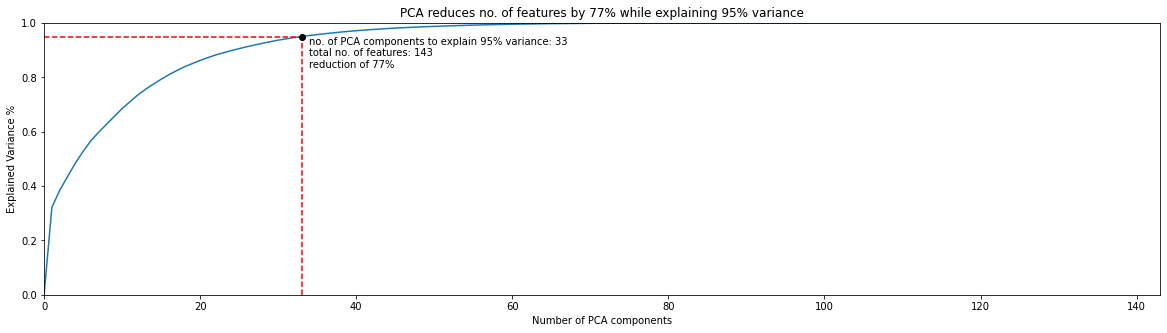

In [ ]:
pca = PCA().fit(season_prepared)
pca_cumsum = np.cumsum(pca.explained_variance_ratio_)
# aim for 95% variance explained
target = np.argmax(pca_cumsum >= 0.95) + 1 # python starts counting at 0
plt.plot([*range(0,len(pca_cumsum)+1)], [0, *pca_cumsum])
plt.xlim(0,len(pca_cumsum))
plt.ylim(0,1)
plt.xlabel("Number of PCA components")
plt.ylabel("Explained Variance %")
plt.plot([target, target], [0, 0.95], 'r--')
plt.plot([0, target], [0.95, 0.95], 'r--')
plt.plot(target, 0.95, 'ko')
plt.annotate(f"no. of PCA components to explain 95% variance: {target}\n" + 
             f"total no. of features: {pca.n_features_in_}\n" + 
             f"reduction of {(pca.n_features_in_ - target) / pca.n_features_in_:0.0%}", 
             [target+1, 0.95],
             ha = 'left',
             va = 'top')
plt.title(f"PCA reduces no. of features by {(pca.n_features_in_ - target) / pca.n_features_in_:0.0%} while explaining 95% variance")
plt.show()

In [ ]:
# don't add to data_preparation pipeline
# while PCA can help reduce no. of features significantly, reduce training time and avoid axis orientation issues in decision tree, 
# I want to keep features interpretable given the dataset is not too large

# data_preparation.steps.append(
#     ("pca", PCA(n_components=0.95))
# )

In [ ]:
# print(f"target no. of features to explain 95% variance = {data_preparation.fit_transform(season).shape[1]}")

## Feature selection with lasso penalty
- use lasso penalty with logistic regression to select useful features
- threshold = hyperparameter to tune

In [ ]:
selector = SelectFromModel(
    LogisticRegression(penalty='l1', random_state=42, solver='liblinear'),
    threshold=None # hyperparameter to tune
    ).fit(season_prepared, season_label.reshape(-1,))

In [ ]:
# hyperparameter to tune
selector.threshold_

1e-05

In [ ]:
# original training set
season.shape

(3145, 194)

In [ ]:
# reduced no. of features
selector.transform(season_prepared).shape

(3145, 60)

In [ ]:
# columns dropped
sorted(season_prepared.columns[~selector.get_support()])

['AST',
 'AST_OPP',
 'AST_PCT_OPP',
 'AST_RATIO',
 'AST_RATIO_OPP',
 'DEF_RATING',
 'DEF_RATING_OPP',
 'DREB',
 'DREB_OPP',
 'DREB_PCT',
 'EFG_PCT',
 'EFG_PCT_OPP',
 'ERA_0',
 'ERA_1',
 'FG3A',
 'FG3A_OPP',
 'FGA',
 'FGA_OPP',
 'FTA',
 'FTA_RATE',
 'FTA_RATE_OPP',
 'OPP_DREB',
 'OPP_DREB_OPP',
 'OPP_EFG_PCT',
 'OPP_EFG_PCT_OPP',
 'OPP_FG3A',
 'OPP_FG3A_OPP',
 'OPP_FGA',
 'OPP_FGA_OPP',
 'OPP_FTA_RATE',
 'OPP_FTA_RATE_OPP',
 'OPP_FT_PCT',
 'OPP_FT_PCT_OPP',
 'OPP_OREB_PCT',
 'OPP_OREB_PCT_OPP',
 'OPP_PF',
 'OPP_PF_OPP',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_2ND_CHANCE_OPP',
 'OPP_PTS_FB',
 'OPP_PTS_FB_OPP',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_OFF_TOV_OPP',
 'OPP_PTS_PAINT',
 'OPP_PTS_PAINT_OPP',
 'OPP_REB_OPP',
 'OPP_TOV',
 'OPP_TOV_OPP',
 'OPP_TOV_PCT',
 'OPP_TOV_PCT_OPP',
 'OREB_PCT',
 'OREB_PCT_OPP',
 'PCT_AST_2PM',
 'PCT_AST_2PM_OPP',
 'PCT_AST_3PM',
 'PCT_AST_3PM_OPP',
 'PCT_AST_FGM_OPP',
 'PCT_FGA_2PT',
 'PCT_FGA_2PT_OPP',
 'PCT_FGA_3PT',
 'PCT_FGA_3PT_OPP',
 'PCT_PTS_2PT',
 'PCT_PTS_2PT_MR'

In [ ]:
# columns retained
sorted(selector.get_feature_names_out())

['AST_PCT',
 'AST_TO',
 'AST_TO_OPP',
 'BLK',
 'BLKA',
 'BLKA_OPP',
 'BLK_OPP',
 'DREB_PCT_OPP',
 'FG3_PCT',
 'FG3_PCT_OPP',
 'FG_PCT',
 'FG_PCT_OPP',
 'FTA_OPP',
 'FT_PCT',
 'FT_PCT_OPP',
 'HOME',
 'OFF_RATING',
 'OFF_RATING_OPP',
 'OPP_AST',
 'OPP_AST_OPP',
 'OPP_BLK',
 'OPP_BLKA',
 'OPP_BLKA_OPP',
 'OPP_BLK_OPP',
 'OPP_FG3_PCT',
 'OPP_FG3_PCT_OPP',
 'OPP_FG_PCT',
 'OPP_FG_PCT_OPP',
 'OPP_FTA',
 'OPP_FTA_OPP',
 'OPP_OREB',
 'OPP_OREB_OPP',
 'OPP_PFD',
 'OPP_PFD_OPP',
 'OPP_PTS',
 'OPP_PTS_OPP',
 'OPP_REB',
 'OPP_STL',
 'OPP_STL_OPP',
 'OREB',
 'OREB_OPP',
 'PACE',
 'PACE_OPP',
 'PCT_AST_FGM',
 'PCT_PTS_OFF_TOV',
 'PCT_PTS_OFF_TOV_OPP',
 'PCT_PTS_PAINT',
 'PCT_PTS_PAINT_OPP',
 'PCT_UAST_FGM_OPP',
 'PF',
 'PF_OPP',
 'PTS',
 'PTS_2ND_CHANCE',
 'PTS_2ND_CHANCE_OPP',
 'PTS_FB',
 'PTS_FB_OPP',
 'PTS_OPP',
 'PTS_PAINT',
 'STL',
 'STL_OPP']

## Final pipeline = data_preparation



In [ ]:
num_pipeline

Pipeline(steps=[('fixpf-1', FixPF(col_drop='PFD', col_replace='OPP_PF')),
                ('fixpf-2',
                 FixPF(col_drop='PFD_OPP', col_replace='OPP_PF_OPP')),
                ('dropcols',
                 DropCols(cols_drop=['GP', 'W', 'L', 'W_PCT', 'PFD', 'MIN',
                                     'FGM', 'FG3M', 'FTM', 'OPP_FGM',
                                     'OPP_FG3M', 'OPP_FTM', 'TM_TOV_PCT', 'REB',
                                     'REB_PCT', 'PLUS_MINUS', 'NET_RATING',
                                     'PACE_PER40', 'POSS', 'PIE', 'GP_OPP',
                                     'W_OPP', 'L_OPP', 'W_PCT_OPP', 'PFD_OPP',
                                     'MIN_OPP', 'FGM_OPP', 'FG3M_OPP',
                                     'FTM_OPP', 'OPP_FGM_OPP', ...])),
                ('myminmaxscaler', MyMinMaxScaler()),
                ('season', SeasonSimilarity(n_clusters=2, random_state=42))])

In [ ]:
data_preparation = make_pipeline(
    
    # data cleaning
    ColumnTransformer([
        # fixing columns / drop columns / quantile transform / clustering numeric columns
        ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
      ], 
      # drop remaining string columns such as TEAM_ID
      remainder="drop",
      # drop column prefix
      verbose_feature_names_out = False, 
    ),

    # feature selection
    SelectFromModel(
      LogisticRegression(penalty='l1', random_state=42, solver='liblinear'),
      threshold=None # hyperparameter to tune
    )
)

In [ ]:
data_preparation

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('fixpf-1',
                                                                   FixPF(col_drop='PFD',
                                                                         col_replace='OPP_PF')),
                                                                  ('fixpf-2',
                                                                   FixPF(col_drop='PFD_OPP',
                                                                         col_replace='OPP_PF_OPP')),
                                                                  ('dropcols',
                                                                   DropCols(cols_drop=['GP',
                                                                                       'W',
                                                                                       'L',
             

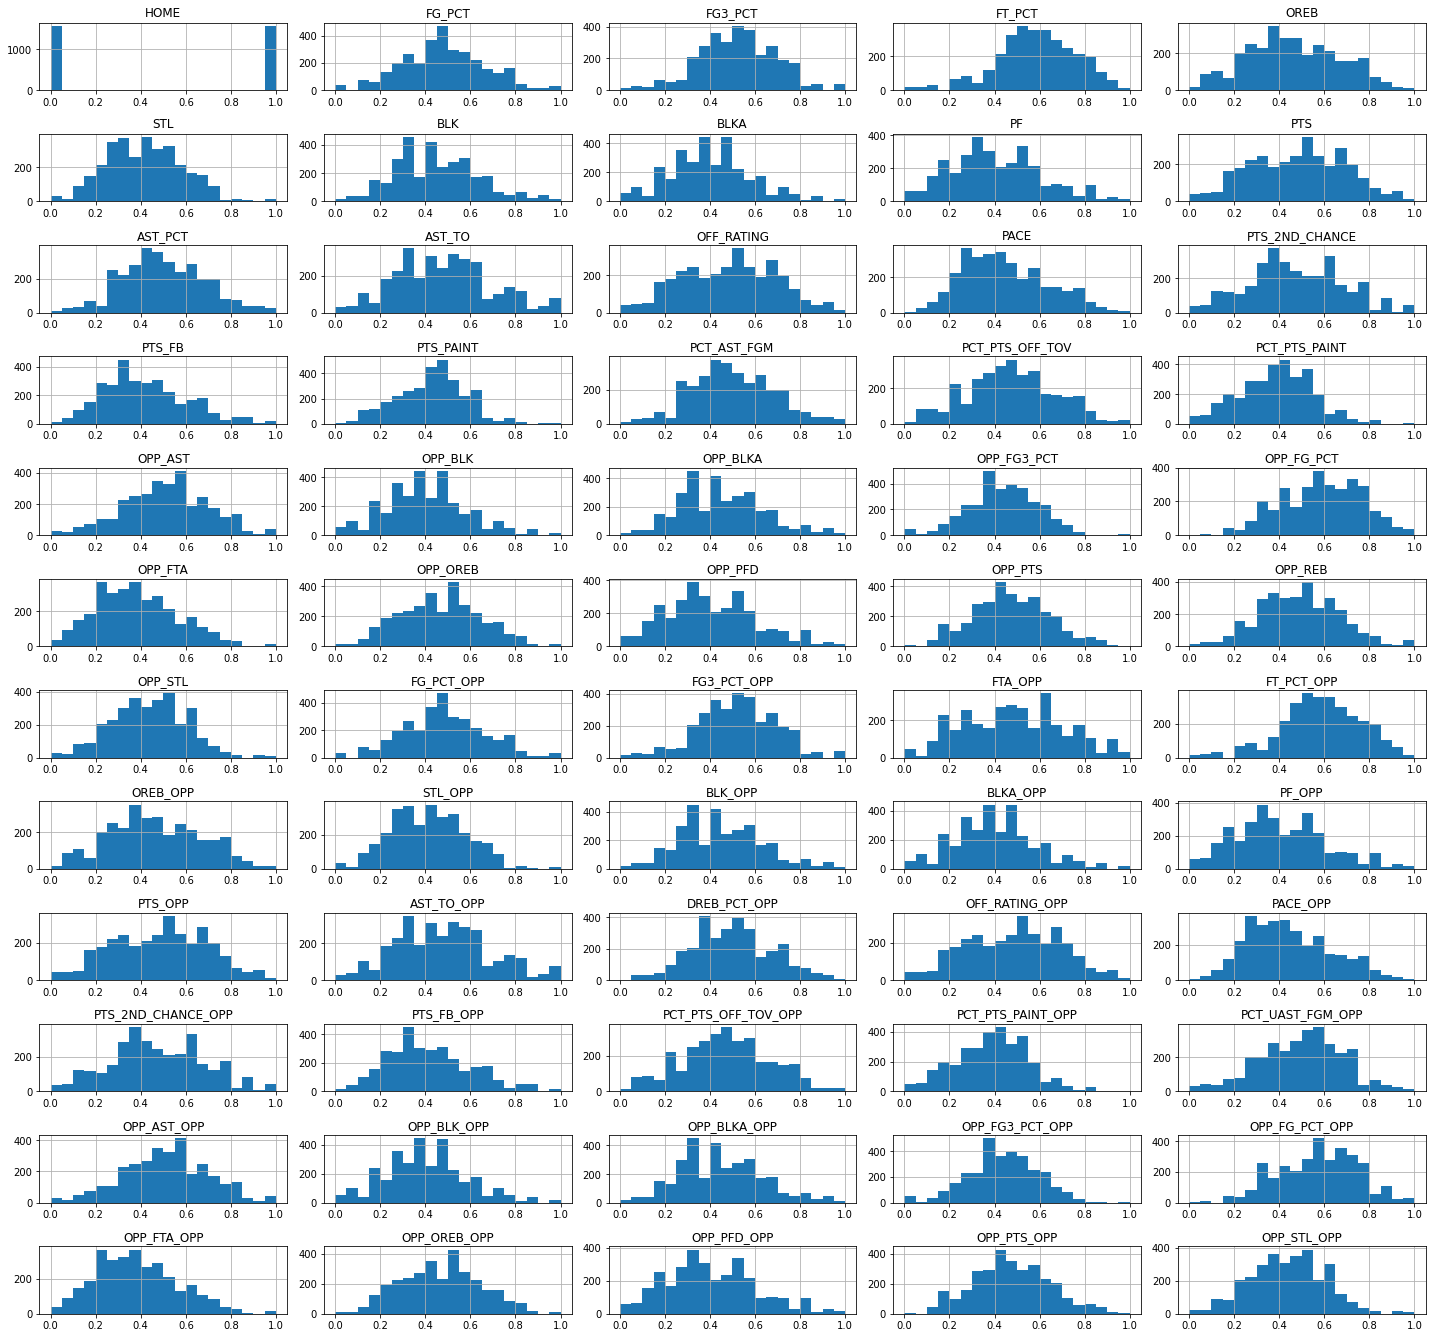

In [ ]:
# plot distributions of each feature in X_train
plot_df = pd.DataFrame(data_preparation.fit_transform(season, season_label), 
                       columns = data_preparation.get_feature_names_out()).astype(float)
plot_df.hist(bins = 20, layout = (int(plot_df.shape[1] / 5) + 1, 5), figsize = (20,20))
plt.title("Distribution of each feature after cleaning")
plt.tight_layout()

# Shortlist promising models

In [ ]:
# create a list of models using standard hyperparameters to compare performance
dict_clf = {
    # 1) need predict_proba() for all classifiers such that we can use some ensemble methods later
    # 2) class imbalance in data
      # current method: rebalance class weight
      # alternative: sampling methods, e.g. oversampling, undersampling, SMOTE, ADA
      # medium article: 

    "knn": KNeighborsClassifier(),
    "sgd": SGDClassifier(random_state=42, loss='log', penalty='elasticnet'), # SGD solver for logistic regression
    "logistic": LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.15, max_iter=10**4),
    "svc": SVC(kernel='linear', random_state=42, probability=True), # SVC instead of LinearSVC for predict_proba()
    # "svc_poly": SVC(kernel='poly', random_state=42, probability=True), # probability=True for predict_proba()
    # "svc_rbf": SVC(kernel='rbf', random_state=42, probability=True), # probability=True for predict_proba()
    "tree": DecisionTreeClassifier(random_state=42),
    "forest": RandomForestClassifier(random_state=42),
    "gb": GradientBoostingClassifier(random_state=42),
    "ada": AdaBoostClassifier(random_state=42),
    "xgb": XGBClassifier(random_state=42),
    "xgbrf": XGBRFClassifier(random_state=42)
}

In [ ]:
list_clf = []
AP_CVs = []
AP_train = []
list_precision = []
list_recall = []
list_thresholds = []

cv = 10

# fit each classification algorithm and calculate 10-fold CV AP
for key, item in tqdm(dict_clf.items()):
  print(key)
  # add estimator after data_preparation pipeline
  clf = Pipeline(
      data_preparation.steps + [(key, item)]
      ).fit(season, season_label)
  
  # cross validation score
  AP_CV = cross_val_score(clf, season, season_label, cv = cv, scoring = 'average_precision')
  # cross validation predict 
  try:
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'predict_proba')[:,1] # second column = probability of positive class
  # if the classifier does not have decision_function attribute, then use predict_proba
  except AttributeError:
    print(f"{key} doesn't have predict_proba() method")
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'decision_function')
  
  precision, recall, thresholds = precision_recall_curve(season_label, y_scores)

  list_clf.append(key)
  AP_CVs.append(AP_CV)
  AP_train.append(average_precision_score(season_label, clf.predict_proba(season)[:,1]))
  list_precision.append(precision)
  list_recall.append(recall)
  list_thresholds.append(thresholds)

  0%|          | 0/10 [00:00<?, ?it/s]

knn


 10%|█         | 1/10 [00:51<07:46, 51.86s/it]

sgd


 20%|██        | 2/10 [01:43<06:56, 52.01s/it]

logistic


 30%|███       | 3/10 [02:44<06:30, 55.78s/it]

svc


 40%|████      | 4/10 [04:40<07:58, 79.81s/it]

tree


 50%|█████     | 5/10 [05:33<05:49, 69.88s/it]

forest


 60%|██████    | 6/10 [06:48<04:47, 71.80s/it]

gb


 70%|███████   | 7/10 [08:37<04:11, 83.91s/it]

ada


 80%|████████  | 8/10 [09:39<02:33, 76.96s/it]

xgb


 90%|█████████ | 9/10 [10:43<01:12, 72.89s/it]

xgbrf


100%|██████████| 10/10 [11:43<00:00, 70.36s/it]


In [ ]:
# sort the models by AP but not other performance metrics dependent on decision threshold, e.g. precision and recall
mean_AP = [np.mean(AP) for AP in AP_CVs]
sd_AP = [np.std(AP) for AP in AP_CVs]
print("Models sorted by cross validation AP score")
for mean, sd, clf_name in sorted(zip(mean_AP, sd_AP, list_clf), reverse = True):
  print(f"CV AP: AVG {mean:0.4f} / SD {sd:0.4f} / {clf_name}")

Models sorted by cross validation AP score
CV AP: AVG 0.6767 / SD 0.0482 / svc
CV AP: AVG 0.6730 / SD 0.0483 / logistic
CV AP: AVG 0.6650 / SD 0.0637 / xgbrf
CV AP: AVG 0.6636 / SD 0.0460 / sgd
CV AP: AVG 0.6617 / SD 0.0517 / xgb
CV AP: AVG 0.6606 / SD 0.0493 / gb
CV AP: AVG 0.6331 / SD 0.0638 / forest
CV AP: AVG 0.6128 / SD 0.0546 / ada
CV AP: AVG 0.5614 / SD 0.0401 / knn
CV AP: AVG 0.5477 / SD 0.0283 / tree


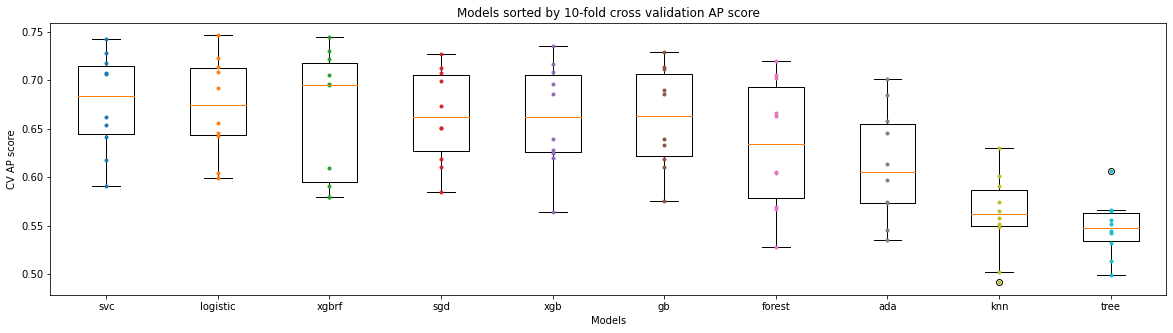

In [ ]:
# sort the models and plot the spread of CV AP scores
mean_AP = [np.mean(AP) for AP in AP_CVs]
sorted_AP_CV = [i for _, i in [(mean_AP[i], AP_CVs[i]) for i in np.argsort(mean_AP)[::-1]]]
sorted_clf = [i for _, i in [(mean_AP[i], list_clf[i]) for i in np.argsort(mean_AP)[::-1]]]
sorted_AP_train = [i for _, i in [(mean_AP[i], AP_train[i]) for i in np.argsort(mean_AP)[::-1]]]
plt.boxplot(sorted_AP_CV, labels=sorted_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_AP_CV):
  plt.plot([i+1]*len(AP), AP, ".")
# plt.plot([*range(1,len(sorted_AP_CV)+1,1)], sorted_AP_train, "ks")
plt.title(f"Models sorted by {cv}-fold cross validation AP score")
plt.xlabel("Models")
plt.ylabel("CV AP score")
plt.show()

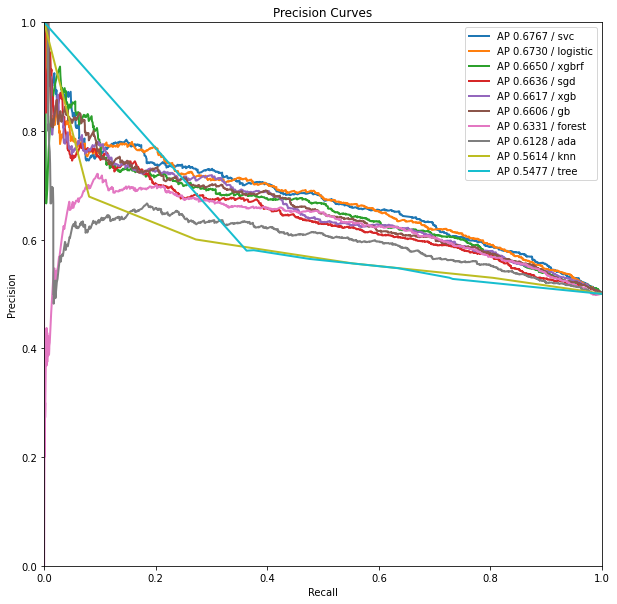

In [ ]:
figure(figsize=(10, 10))
for AP, precision, recall, thresholds, clf_name in [(mean_AP[i], list_precision[i], list_recall[i], list_thresholds[i], list_clf[i]) for i in np.argsort(mean_AP)[::-1]]:
  # if clf_name == 'tree':
  # plt.plot(thresholds, precision[:-1], linewidth = 2, label = f"AP {AP:0.4f} / {clf_name}")
    plt.plot(recall, precision, linewidth = 2, label = f"AP {AP:0.4f} / {clf_name}")
# plt.plot([0,1], [0,1], 'k:', label = "AP 0.5000 / random guess")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Precision Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# Fine-tune hyperparameters of shortlisted models with RandomizedSearchCV

In [ ]:
# print top models to tune
top = 5
for name in sorted_clf[:top]:
  print(name, dict_clf[name])

logistic LogisticRegression(l1_ratio=0.15, max_iter=10000, penalty='elasticnet',
                   random_state=42, solver='saga')
svc SVC(kernel='linear', probability=True, random_state=42)
sgd SGDClassifier(loss='log', penalty='elasticnet', random_state=42)
xgbrf XGBRFClassifier(random_state=42)
xgb XGBClassifier(random_state=42)


In [ ]:
# testing reasonable range of hyperparameters before RandomizedSearchCV
# expon = False
# count = 1
# for i in range(1,10**2,10**1):
#   if expon:
#     count = count * i/10**20 / (i/10**22)
#     i = count
#   else:
#     i = i/10**2
#   full_pipeline = make_pipeline(
#       data_preparation,
#       AdaBoostClassifier(random_state=42, learning_rate=i)
#   )

#   full_pipeline.fit(season, season_label)
#   cv_score = cross_val_score(full_pipeline, season, season_label, cv = 5, scoring='roc_auc')
#   auc_train = roc_auc_score(season_label, full_pipeline.predict_proba(season)[:,1])
#   print(f"choice {i}, CV AUC {cv_score}")
#   print(f"mean AUC {np.mean(cv_score):0.4f}, std AUC {np.std(cv_score):0.4f} / train AUC {auc_train:0.4f}")
#   # print(full_pipeline.get_params().keys())
#   # plt.hist([np.log2(x) for x in loguniform(a=2**-2, b=2**2).rvs(size=10**6)])

## Set up hyperparameter grid

In [ ]:
# create a list of hyperparameters to tune for each shortlisted classifier
shortlisted_clfs = {
    "xgb": XGBClassifier(random_state=42),
    # "ada": AdaBoostClassifier(random_state=42),
    # "gb": GradientBoostingClassifier(random_state=42),
    # "forest": RandomForestClassifier(random_state=42),
    # "tree": DecisionTreeClassifier(random_state=42),
    "xgbrf": XGBRFClassifier(random_state=42),
    "logistic": LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.15, max_iter=10**4),
    "svc": SVC(kernel='linear', probability=True, max_iter=10**5, random_state=42),
    # "svc_poly": SVC(kernel='poly', probability=True, random_state=42),
    # "svc_rbf": SVC(kernel='rbf', probability=True, random_state=42),
    "sgd": SGDClassifier(random_state=42, penalty='elasticnet', loss='log')
    
}

param_grids = {
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
    "xgb": {
        "xgb__gamma": uniform(loc = 0, scale = 10),
        "xgb__reg_alpha": uniform(loc = 0, scale = 10),
        "xgb__reg_gamma": uniform(loc = 0, scale = 10),
        "xgb__learning_rate": uniform(loc = 0.01, scale = 1),
        "xgb__max_depth": randint(low = 1, high = 5),
        "xgb__min_child_weight": randint(low = 1, high = 30),
    },

    "xgbrf": {
        "xgbrf__gamma": uniform(loc = 0, scale = 10),
        "xgbrf__reg_alpha": uniform(loc = 0, scale = 10),
        "xgbrf__reg_gamma": uniform(loc = 0, scale = 10),
        "xgbrf__learning_rate": uniform(loc = 0.01, scale = 1),
        "xgbrf__max_depth": randint(low = 1, high = 5),
        "xgbrf__min_child_weight": randint(low = 1, high = 30),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier
    "forest": {
        "forest__max_depth": randint(low = 3, high = 5),
        "forest__min_samples_split": uniform(loc = 0.1, scale = 0.5),
        # "forest__min_samples_leaf": uniform(loc = 0.01, scale = 0.2)
    },

    "tree": {
        "tree__criterion": ['gini', 'entropy'],
        "tree__max_depth": randint(low = 3, high = 5),
        "tree__min_samples_split": uniform(loc = 0.1, scale = 0.5),
        # "tree__min_samples_leaf": uniform(loc = 0.01, scale = 0.2)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier
    "ada": {
        "ada__learning_rate": loguniform(a = 10**-2, b = 10**0),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradientboost#sklearn.ensemble.GradientBoostingClassifier
    "gb": {
        "gb__min_samples_split": uniform(loc = 0.1, scale = 0.5),
        "gb__max_depth": randint(low = 1, high = 5),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    "logistic": {
        "logistic__C": loguniform(a = 10**-3, b = 10**-1),
        "logistic__l1_ratio": uniform(loc = 0, scale = 1),
    },

     # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC
    "svc_poly": {
        "svc_poly__C": loguniform(a = 10**-20, b = 10**1)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC
    "svc": {
        "svc__C": loguniform(a = 10**-20, b = 10**1)
    },


    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC
    "svc_rbf": {
        "svc_rbf__C": loguniform(a = 10**-20, b = 10**1)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgdclassifier#sklearn.linear_model.SGDClassifier
    "sgd": {
        "sgd__l1_ratio": uniform(loc = 0, scale = 1),
        "sgd__alpha": loguniform(a = 10**-3, b = 10**-1),
        "sgd__learning_rate": ['optimal', 'adaptive'],
        "sgd__eta0": loguniform(a = 10**-3, b = 10**-1)
    }
    
}

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Project-NBAGames')

Mounted at /content/drive


In [ ]:
random_clfs = []
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

for clf_name, clf in tqdm(shortlisted_clfs.items()):

  full_pipeline = Pipeline(
      data_preparation.steps + [(clf_name, clf)]
      )

  print(clf_name)
  print(clf)
  
  param_grid = copy.deepcopy(param_grids[clf_name])
  # tune C for inverse of regularization strength in lasso penalty for feature selection in data_prepartion pipeline
  param_grid["selectfrommodel__threshold"] = loguniform(a = 10**-5, b = 10**0)
  
  print(param_grid)

  random_search = RandomizedSearchCV(full_pipeline, 
                                    param_grid, 
                                    cv = 10, 
                                    n_iter = 100, 
                                    scoring = "average_precision",
                                    random_state = 42,
                                    n_jobs = -1,
                                    error_score = 'raise')

  random_search.fit(season, season_label)
  random_clfs.append(random_search)

  print(f"\nbest_score: {random_search.best_score_}")
  print(f"best_params: {random_search.best_params_}")
  # print(pd.DataFrame(random_search.cv_results_))

  print(f'{clf_name} AP playoff games {random_search.best_estimator_.steps[-1][0]} dumped {current_time}')
  dump(random_search, f'{clf_name}_tuned_AP_playoff_games_{current_time}.joblib') 

  0%|          | 0/5 [00:00<?, ?it/s]

xgb
XGBClassifier(random_state=42)
{'xgb__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6ae6ffdd0>, 'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6adab50d0>, 'xgb__reg_gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6ae039090>, 'xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6ae039f10>, 'xgb__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6ae0393d0>, 'xgb__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6acb68810>, 'selectfrommodel__threshold': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6ac7a7150>}


 20%|██        | 1/5 [25:06<1:40:27, 1506.89s/it]


best_score: 0.671808517861362
best_params: {'selectfrommodel__threshold': 2.769889922756281e-05, 'xgb__gamma': 1.959828624191452, 'xgb__learning_rate': 0.05522728891053807, 'xgb__max_depth': 4, 'xgb__min_child_weight': 21, 'xgb__reg_alpha': 3.8867728968948203, 'xgb__reg_gamma': 2.713490317738959}
xgb AP playoff games xgb dumped 20220929_043406
xgbrf
XGBRFClassifier(random_state=42)
{'xgbrf__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6a8474610>, 'xgbrf__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6a8474c50>, 'xgbrf__reg_gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6ac882c50>, 'xgbrf__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6a81d9e90>, 'xgbrf__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6a83078d0>, 'xgbrf__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6ab4b6590>, 'selectfrommodel__threshold': <scipy.stats._distn_infr

 40%|████      | 2/5 [48:59<1:13:09, 1463.02s/it]


best_score: 0.6746621133870405
best_params: {'selectfrommodel__threshold': 0.01808938738468222, 'xgbrf__gamma': 2.066843598767454, 'xgbrf__learning_rate': 0.28396112732113377, 'xgbrf__max_depth': 4, 'xgbrf__min_child_weight': 14, 'xgbrf__reg_alpha': 0.18221825651549728, 'xgbrf__reg_gamma': 0.944429607559284}
xgbrf AP playoff games xgbrf dumped 20220929_043406
logistic
LogisticRegression(l1_ratio=0.15, max_iter=10000, penalty='elasticnet',
                   random_state=42, solver='saga')
{'logistic__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6a8404050>, 'logistic__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6a8404a90>, 'selectfrommodel__threshold': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6afbbc910>}


 60%|██████    | 3/5 [1:09:30<45:14, 1357.26s/it]


best_score: 0.6898136424711038
best_params: {'logistic__C': 0.09413993046829941, 'logistic__l1_ratio': 0.7722447692966574, 'selectfrommodel__threshold': 9.853225172032554e-05}
logistic AP playoff games logistic dumped 20220929_043406
svc
SVC(kernel='linear', max_iter=100000, probability=True, random_state=42)
{'svc__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6a844b310>, 'selectfrommodel__threshold': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6ae03fe50>}


 80%|████████  | 4/5 [2:05:25<35:46, 2146.08s/it]


best_score: 0.6850169349533103
best_params: {'selectfrommodel__threshold': 0.014689898077648806, 'svc__C': 0.019983538610271363}
svc AP playoff games svc dumped 20220929_043406
sgd
SGDClassifier(loss='log', penalty='elasticnet', random_state=42)
{'sgd__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6adb5fd50>, 'sgd__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6abe9e050>, 'sgd__learning_rate': ['optimal', 'adaptive'], 'sgd__eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6abe9eb90>, 'selectfrommodel__threshold': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6ad88df10>}


100%|██████████| 5/5 [2:26:00<00:00, 1752.03s/it]


best_score: 0.6904077630420362
best_params: {'selectfrommodel__threshold': 0.00026558434508499874, 'sgd__alpha': 0.0011851515660043107, 'sgd__eta0': 0.016562605893335948, 'sgd__l1_ratio': 0.5026790232288615, 'sgd__learning_rate': 'adaptive'}
sgd AP playoff games sgd dumped 20220929_043406


## Check CV result after hyperparameter tuning

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Project-NBAGames')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tuned_models = {}
time_list = []
time_diff = []
match_pattern = '_tuned_AP_playoff_games_(\w+).joblib'

for time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(time)

latest = time_list[np.argmin(time_diff)]
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[-1][0]] = model
  print(model.best_estimator_.steps[-1][0], "playoff games AP loaded")

xgb playoff games AP loaded
xgbrf playoff games AP loaded
logistic playoff games AP loaded
svc playoff games AP loaded
sgd playoff games AP loaded


### Average precision

In [ ]:
# pull the CV AP results from RandomizedSearchCV
tuned_AP = []
for clf_name, model in tuned_models.items():
  # tuned_AP.append(cross_val_score(model.best_estimator_, season, season_label, cv = 10, scoring='average_precision'))
  cv_AP_colindex = [i for i, x in enumerate(model.cv_results_.keys()) if re.search('split\w+_test_score', x) is not None]
  tuned_AP.append(pd.DataFrame(model.cv_results_).iloc[model.best_index_,cv_AP_colindex].values)

In [ ]:
from sklearn.metrics import average_precision_score
# sort the models and plot the spread of CV AP scores
mean_tuned_AP = [np.mean(auc) for auc in tuned_AP]
mean_train_AP = [average_precision_score(season_label, model.best_estimator_.predict_proba(season)[:,1]) for _, model in tuned_models.items()]
sorted_tuned_AP = [i for _, i in sorted(zip(mean_tuned_AP, tuned_AP), reverse = True)]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_tuned_AP, tuned_models.keys()), reverse = True)]
sorted_train_AP = [i for _, i in sorted(zip(mean_tuned_AP, mean_train_AP), reverse = True)]

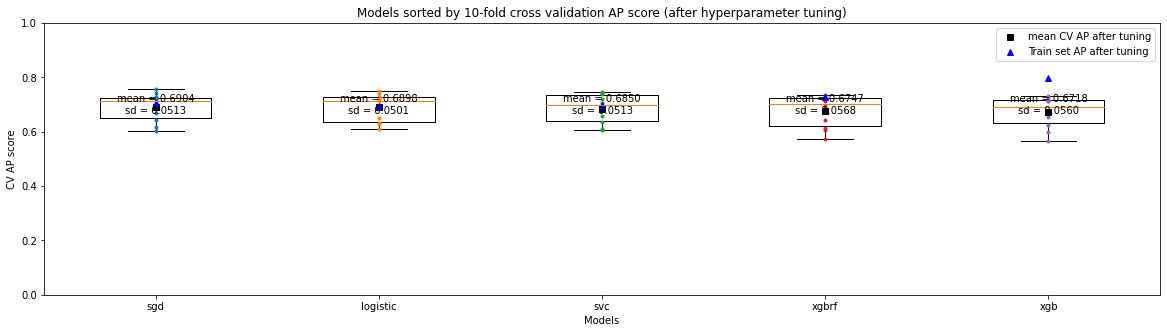

In [ ]:
plt.boxplot(sorted_tuned_AP, labels=sorted_tuned_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_tuned_AP):
  plt.plot([i+1]*len(AP), AP, ".")
  plt.annotate(f"mean = {np.mean(AP):0.4f}\nsd = {np.std(AP):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted(mean_tuned_AP, reverse=True), 
         "ks", label = 'mean CV AP after tuning')
plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted_train_AP, 
         "b^", label = 'Train set AP after tuning')
# plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], [mean_AP[list_clf.index(x)] for x in sorted_tuned_clf], 
#          "k^", label = 'mean CV AP before tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation AP score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0,1)
plt.ylabel("CV AP score")
plt.show()

### AUROC

In [ ]:
list_clf = []
auc_CVs = []
auc_train = []
list_precision = []
list_recall = []
list_thresholds = []

cv = 10

# fit each classification algorithm and calculate 10-fold CV AUC
for key, item in tqdm(tuned_models.items()):
  clf = item.best_estimator_.fit(season, season_label)
  auc_CV = cross_val_score(clf, season, season_label, cv = cv, scoring = 'roc_auc')
  try:
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'predict_proba')[:,1] # second column = probability of positive class
  # if the classifier does not have decision_function attribute, then use predict_proba
  except AttributeError:
    print(f"{key} doesn't have predict_proba() method")
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'decision_function')
  
  precision, recall, thresholds = precision_recall_curve(season_label, y_scores)

  list_clf.append(key)
  auc_CVs.append(auc_CV)
  auc_train.append(roc_auc_score(season_label, clf.predict_proba(season)[:,1]))
  list_precision.append(precision)
  list_recall.append(recall)
  list_thresholds.append(thresholds)

100%|██████████| 5/5 [04:34<00:00, 54.84s/it]


In [ ]:
sorted_tuned_AUC = [i for _, i in sorted(zip(mean_tuned_AP, auc_CVs), reverse = True)]
sorted_train_AUC = [i for _, i in sorted(zip(mean_tuned_AP, auc_train), reverse = True)]

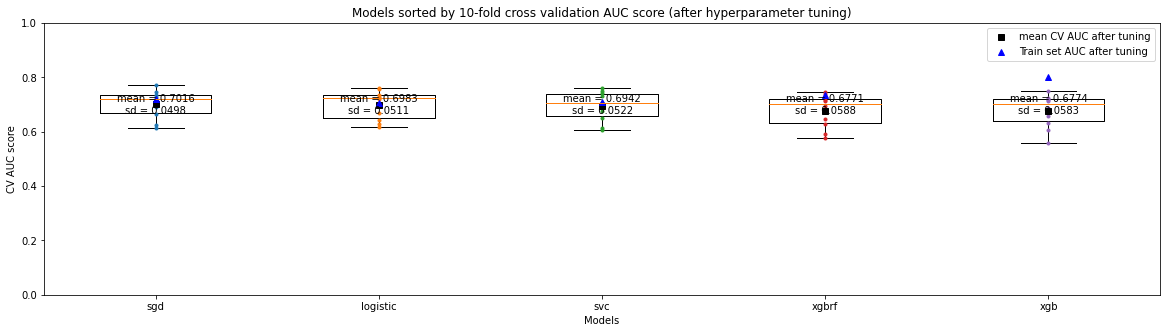

In [ ]:
plt.boxplot(sorted_tuned_AUC, labels=sorted_tuned_clf)
# add dots for CV AUC scores
for i, AUC in enumerate(sorted_tuned_AUC):
  plt.plot([i+1]*len(AUC), AUC, ".")
  plt.annotate(f"mean = {np.mean(AUC):0.4f}\nsd = {np.std(AUC):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], [np.mean(x) for x in sorted_tuned_AUC], 
         "ks", label = 'mean CV AUC after tuning')
plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], sorted_train_AUC, 
         "b^", label = 'Train set AUC after tuning')
# plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], [mean_AUC[list_clf.index(x)] for x in list_clf], 
#          "k^", label = 'mean CV AUC before tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation AUC score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0,1)
plt.ylabel("CV AUC score")
plt.show()

### coefficients and precision-recall curve

In [ ]:
best_model = tuned_models['sgd'].best_estimator_

Number of features after fitting estimator with regularization: 
38
features = ['HOME', 'OPP_FG3_PCT', 'OPP_FG3_PCT_OPP', 'PTS_OPP', 'OFF_RATING_OPP', 'PTS', 'OFF_RATING', 'FG_PCT_OPP', 'FG_PCT', 'OPP_FG_PCT', 'OPP_FG_PCT_OPP', 'PCT_PTS_OFF_TOV', 'PCT_PTS_OFF_TOV_OPP', 'PCT_PTS_PAINT_OPP', 'OPP_AST_OPP', 'OPP_PTS', 'OPP_AST', 'PTS_PAINT', 'OPP_PTS_OPP', 'OPP_REB', 'FT_PCT', 'DREB_PCT_OPP', 'OPP_BLK', 'BLKA', 'FT_PCT_OPP', 'OPP_BLK_OPP', 'BLKA_OPP', 'PTS_FB_OPP', 'PTS_FB', 'FTA_OPP', 'OPP_FTA', 'PF', 'OPP_PFD', 'OPP_FTA_OPP', 'OPP_STL_OPP', 'PCT_PTS_PAINT', 'PF_OPP', 'OPP_PFD_OPP']
coefficient = [1.0388, -0.8222, 0.7886, -0.7386, -0.7386, 0.6861, 0.6861, -0.6586, 0.5295, -0.4749, 0.4513, -0.4021, 0.3908, -0.3611, 0.3537, -0.3433, -0.3384, 0.3187, 0.3178, -0.3006, -0.1896, -0.1632, -0.1594, -0.1594, 0.158, 0.1546, 0.1546, -0.1527, 0.1374, -0.1084, -0.1083, -0.1055, -0.1055, 0.1023, -0.097, 0.0919, 0.0813, 0.0813]


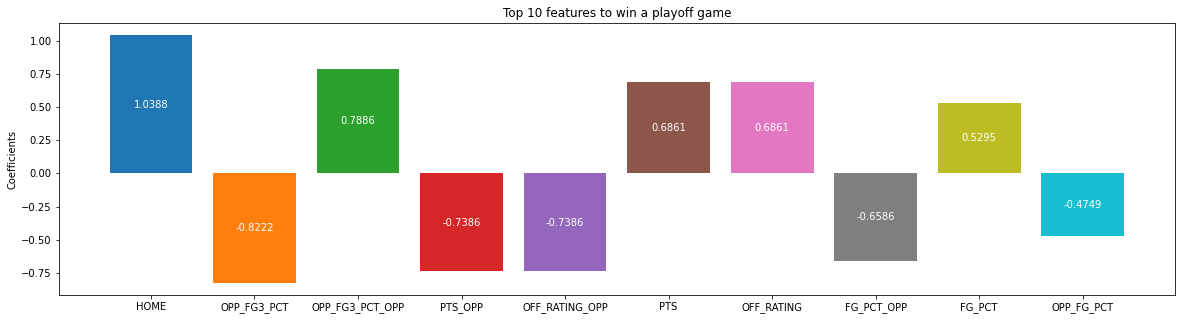

In [ ]:
# non-zero (signficant) features after regularization in fitting estimator
features_out = best_model[:-1].get_feature_names_out() 
try:
  coef = best_model.steps[-1][1].feature_importances_
except:
  coef = best_model.steps[-1][1].coef_[0]
print(f"Number of features after fitting estimator with regularization: \n{np.count_nonzero(coef)}")
features_non_zero = [features_out[loc] for loc in np.nonzero(coef)[0]]
coef_non_zero = [np.around(coef[loc], decimals=4) for loc in np.nonzero(coef)[0]]
print(f"features = {[feature_ for _, feature_ in sorted(zip(np.abs(coef_non_zero), features_non_zero), reverse=True)]}")
print(f"coefficient = {[coef_ for _, coef_ in sorted(zip(np.abs(coef_non_zero), coef_non_zero), reverse=True)]}")

abs_coef = np.abs(coef)
fig, ax = plt.subplots(1,1)
top_n = 10
for i, (_, coef, name) in enumerate(sorted(zip(abs_coef, coef, features_out), reverse=True)[:top_n]):
  ax.bar(name, coef)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f"{height:0.4f}",
                xy=(rect.get_x() + rect.get_width() / 2, height/2),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                color = 'white',
                ha='center', va='center')
plt.title(f"Top {top_n} features to win a playoff game")
plt.ylabel("Coefficients")
plt.show()

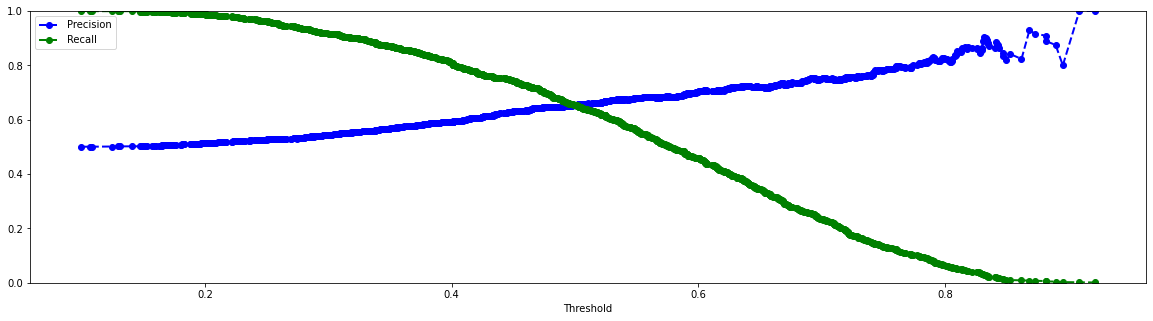

In [ ]:
idx = list_clf.index(best_model.steps[-1][0])
precisions = list_precision[idx]
recalls = list_recall[idx]
thresholds = list_thresholds[idx]
plt.plot(thresholds, precisions[:-1], 'b--o', label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--o", label = "Recall", linewidth = 2)
# plt.axhline(0.9, c='k')
plt.xlabel("Threshold")
plt.ylim(0,1)
plt.legend()
plt.show()

# Ensemble methods
- Combining tuned models with ensemble learning
- Not to use due to loss in interpretability

In [ ]:
# get performance from adaboost and bagging ensemble methods on each tuned model
single_clf_ensemble_models = {
    "Adaboost": AdaBoostClassifier(random_state = 42),
    "Bagging": BaggingClassifier(random_state = 42, n_estimators=50)
}

for ensemble_key, ensemble_model in single_clf_ensemble_models.items():
  for model in sorted_tuned_clf:
    ensemble_model.base_estimator = tuned_models[model].best_estimator_.steps[-1][1]
    ensemble_pipeline = Pipeline(data_preparation.steps + [(ensemble_key, ensemble_model)])

    ensemble_pipeline.fit(season, season_label)
    cv_score = cross_val_score(ensemble_pipeline, season, season_label, cv = 10, scoring = 'average_precision')
    print(f"mean AP = {np.mean(cv_score):0.4f}, std AP = {np.std(cv_score):0.4f}, {ensemble_key} {model}")

mean AP = 0.5002, std AP = 0.0011, Adaboost sgd
mean AP = 0.5002, std AP = 0.0011, Adaboost logistic
mean AP = 0.5783, std AP = 0.0763, Adaboost svc
mean AP = 0.5002, std AP = 0.0011, Adaboost xgbrf
mean AP = 0.5002, std AP = 0.0011, Adaboost xgb
mean AP = 0.6883, std AP = 0.0497, Bagging sgd
mean AP = 0.6903, std AP = 0.0501, Bagging logistic
mean AP = 0.6852, std AP = 0.0509, Bagging svc
mean AP = 0.6810, std AP = 0.0559, Bagging xgbrf
mean AP = 0.6773, std AP = 0.0579, Bagging xgb


In [ ]:
# get performance from voting and stacking ensemble methods on an increasing basket of tuned models
multiple_clf_ensemble_models = {
    "Voting": VotingClassifier(voting = 'soft', estimators = []),
    "Stacking": StackingClassifier(cv = 10, final_estimator=RandomForestClassifier(random_state=43), estimators = [])
}

for ensemble_key, ensemble_model in multiple_clf_ensemble_models.items():
  for i in range(1,len(tuned_models)):
    ensemble_model.estimators = [(model, tuned_models[model].best_estimator_.steps[-1][1]) for model in sorted_tuned_clf[:(i+1)]]
    ensemble_pipeline = Pipeline(data_preparation.steps + [(ensemble_key, ensemble_model)])

    ensemble_pipeline.fit(season, season_label)
    cv_score = cross_val_score(ensemble_pipeline, season, season_label, cv = 10, scoring = 'average_precision')
    print(f"mean AP = {np.mean(cv_score):0.4f}, std AP = {np.std(cv_score):0.4f}, {ensemble_key} {[model for model in sorted_tuned_clf[:(i+1)]]}")

mean AP = 0.6914, std AP = 0.0502, Voting ['sgd', 'logistic']
mean AP = 0.6888, std AP = 0.0524, Voting ['sgd', 'logistic', 'svc']
mean AP = 0.6880, std AP = 0.0535, Voting ['sgd', 'logistic', 'svc', 'xgbrf']
mean AP = 0.6877, std AP = 0.0530, Voting ['sgd', 'logistic', 'svc', 'xgbrf', 'xgb']
mean AP = 0.6455, std AP = 0.0406, Stacking ['sgd', 'logistic']
mean AP = 0.6566, std AP = 0.0513, Stacking ['sgd', 'logistic', 'svc']
mean AP = 0.6640, std AP = 0.0455, Stacking ['sgd', 'logistic', 'svc', 'xgbrf']
mean AP = 0.6613, std AP = 0.0450, Stacking ['sgd', 'logistic', 'svc', 'xgbrf', 'xgb']


# Issue with best_estimator_ in SearchCV
sklearn returns best_estimator_ at best_index_ = highest mean_test_score 
- but if there is a tie based on mean_test_score, sklearn does not return the one with the lowest std_test_score
- https://github.com/scikit-learn/scikit-learn/blob/db8d67c6a10ef37bf58088e414bbe8a7f7160c60/sklearn/model_selection/_search.py#L1260